In [1]:
###the problem is that in some cases the line intercepts with more than one subduction iso chron,
#especially in the west pacific

In [2]:
import numpy as np
import pandas as pd
import sys
sys.path.insert(1, '/Users/andrew/Documents/python/pygplates_rev28_python37_MacOS64')
import pygplates
import xarray as xr
import os
from os import walk

import rockhound as rh
from rockhound.slab2 import ZONES
import pygmt
import slab_tracker_utils as slab
import splits_and_merges as snm
import slab_cross_section_utils as sxs
import slab_workflow

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from matplotlib import cm
from collections import OrderedDict
import cartopy.crs as ccrs
import serpentinite_spreading_grids

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

from shapely.geometry import Polygon
from shapely.geometry import LineString

#for some reason we get repetitive deprecation warnings, so this mutes them
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning) 




In [3]:
#set directories
platedir = '/Users/andrew/Documents/GitHub/EarthBytePlateMotionModel-ARCHIVE/Muller++_2015_AREPS_CORRECTED/'
savedir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'
datadir = '/Users/andrew/Documents/Data/Merdith_sub_zones/'

#model files
rotfile = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS.rot' % platedir
COBs = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_COB_Terranes.gpml' % platedir
coastlines = '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Coastlines.gpml' % platedir
isochrons = '%sAgeGridInput/Global_EarthByte_230-0Ma_GK07_AREPS_Isochrons.gpml' % platedir
input_topology_filename = ['%sGlobal_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml' % platedir,
                           '%sGlobal_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml' % platedir]

rotation_model = pygplates.RotationModel(rotfile)

#topologies for our subduction points
time = 0 

resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)

#some densities
perid_density_g_cm3 = 3.3 #g/cm3
perid_density_g_km3 = perid_density_g_cm3 * 100000**3
perid_density_kg_km3 = perid_density_g_km3 * 1e-3

In [4]:
cross_section_start_points, sub_length, segments, polarity = slab_workflow.get_sub_parameters(shared_boundary_sections)

Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


In [5]:
forward_distance = 3
back_distance = 1

cross_section_start_points, cross_section_end_points = slab_workflow.make_cross_section(forward_distance, back_distance,
                                                   cross_section_start_points, segments, polarity)

#have to convert our longitude points to 0–360 to accommodate rockhound (i think, super annoying)
for ind,i in enumerate(cross_section_end_points[:,1]):
    if i < 0:
        cross_section_end_points[ind][1] = i+360
for ind,i in enumerate(cross_section_start_points[:,1]):
    if i < 0:
        cross_section_start_points[ind][1] = i+360        

Right
0
Right
1
Right
2
Right
3
Right
4
Right
5
Right
6
Right
7
Right
8
Right
9
Right
10
Right
11
Right
12
Right
13
Right
14
Right
15
Right
16
Right
17
Right
18
Right
19
Right
20
Right
21
Right
22
Right
23
Right
24
Right
25
Right
26
Right
27
Right
28
Right
29
Right
30
Right
31
Right
32
Right
33
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Left
Right
84
Right
85
Right
86
Right
87
Right
88
Right
89
Right
90
Right
91
Right
92
Right
93
Right
94
Right
95
Right
96
Right
97
Right
98
Right
99
Right
100
Right
101
Right
102
Left
Left
Left
Left
Left
Right
108
Right
109
Right
110
Right
111
Right
112
Right
113
Right
114
Right
115
Right
116
Right
117
Right
118
Right
119
Right
120
Right
121
Right
122
Right
123
Right
124
Right
125
Right
126
Left
Left
Left
Left
Left
Left
Left
Left
Left
Right
136
Right
137


In [6]:
#load our other data needed to populate the cross section
#open slab2 geometry (made in in Slab2_geometry_Py3 notebook)
ds_in = xr.open_dataset('%sSlab2point0/sub_zones_Slab2.nc' % datadir)
#organise our dataarray so its stacked
ds_stacked = ds_in.stack(x=['latitude','longitude'])


#peridotite grid
grid_filename = ['/Users/andrew/Documents/Data/Chapman_arc_flare_up_DATA/thickness_grids/peridotite_thickness_post_serpentinisation','_Ma.nc',
                 '/Users/andrew/Documents/Data/plate_model_grids/Muller_etal_2016_AREPS_Agegrids_v1.17/Muller_etal_2016_AREPS_v1.17_netCDF/Muller_etal_2016_AREPS_v1.17_AgeGrid-','.nc']
output_data = slab_workflow.get_subducted_slabs(5., 0., 1.0, 
                                                grid_filename, 
                                                ds_stacked)

#close datasets as we no longer need them
#del ds_in
#del ds_stacked



time 5.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 4.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 3.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "" at 3.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 2.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "Woodlark MOR"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "" at 2.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".


time 1.00 Ma


Unable to find the overriding plate of the subducting shared sub-segment "" at 1.0Ma
    both sharing topologies are on subducting side of subducting line.
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "NAM subduction COB" at 1.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
901
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared s

time 0.00 Ma


Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
224
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "So Melanesian-MG-5-20-07"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding plate of the subducting shared sub-segment "NAM subduction COB"
    subduction zone feature is missing subduction polarity property or it is set to "Unknown".
Unable to find the overriding and subducting plates of the subducting shared sub-segment "" at 0.0Ma
    there are not exactly 2 topologies sharing the sub-segment.
911


In [7]:
#get cross section points

steps = 200
cross_section_points, cross_section_lines, intersecting_lines = slab_workflow.populate_cross_section(output_data, cross_section_end_points, 
                       cross_section_start_points, steps)

In [8]:
####
#all sections
# Fetch all Slab2 subduction zones and add them inside a list
subduction_zones = []
for zone in ZONES:
    subduction_zones.append(rh.fetch_slab2(zone))

In [9]:
#here we loop through all our extracted data to get the relevant bits
age_variable = [] #age
perid_variable = [] #peridotite
intersecting_points = []
intersecting_depths = []
intersecting_cross_sections_index = []
nan_cross_section = []
sub_zone_names = []
new_sub_length = []
tracks = []

#loop through points
for ind, points in enumerate(cross_section_points):
    #print(ind)
    #loop through sub zones to find the closest
    for sub_zone in subduction_zones:
        #print(ind, sub_zone.title)
        
        #get depth parameters of sub_zone
        grid = sub_zone.depth
        
        
        ###main calculation, get data from cross sections

        #Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
        track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')#, Verbose=False)
        
        #if our track is empty or has value of 0 we can skip
        if len(track.index) == 0:
            #print('null', ind)
            continue
        if np.sum(track.depth) == 0.0:
            #print('null', ind)
            continue
        
        #but here we have data (i.e. we found what slab our cross section intersected)
        else:
            #print(ind)
            #now we can get the uncertainty
            grid_uncertainty = sub_zone.depth_uncertainty
            
            track_uncertain = pygmt.grdtrack(points=points, grid=grid_uncertainty, 
                                             newcolname='depth_uncertainty')#, Verbose=False)
            
            #the df will contain some NaNs that we want to filter
            track_dropna = track.dropna()
            #we then have to make a copy because i dont quite understand pandas indexing?
            track_dropna_copy = track_dropna.copy()
            
            #sane for depth uncertainty
            track_uncertain_dropna = track_uncertain.dropna()
            track_uncertain_dropna_copy = track_uncertain_dropna.copy()
            
            #our data so far is in - m, lets convert to (positive) km
            track_dropna_copy.loc[:,'depth'] = track_dropna.loc[:,'depth'] * -0.001
            track_uncertain_dropna_copy.loc[:,'depth_uncertainty'] = track_uncertain_dropna.loc[:,'depth_uncertainty'] * 0.001
            
            #get points intersecting the cross section from slab 2.0
            intersecting_points_reversed, intersecting_points_UNUSED, interpolated_variables, interpolated_depths = slab_workflow.get_intersecting_values(intersecting_lines[ind],
                                                                        cross_section_lines[ind])
            
            if not interpolated_variables:
                print('null', ind)
                continue
            print(ind)
            
            #separate age and peridotite variables
#            perid_interpolated_variables = interpolated_variables[::2]
#            age_interpolated_variables = interpolated_variables[1::2]
            #save out values
            perid_variable.append(interpolated_variables[::2])
            age_variable.append(interpolated_variables[1::2])

            intersecting_points.append(intersecting_points_reversed)
            intersecting_depths.append(interpolated_depths)
            intersecting_cross_sections_index.append(ind)
            sub_zone_names.append(sub_zone.title)
            new_sub_length.append(sub_length[ind])
            track_dropna_copy['depth_uncertainty'] = track_uncertain_dropna_copy['depth_uncertainty']
            tracks.append(track_dropna_copy)
            break
            
del grid
del grid_uncertainty
for zone in subduction_zones:
    del zone

0
1
2
3
4
5
6
7
8
9
10
11
12
null 13
null 13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
null 63
null 63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
162
163
164
165
166
167
168
169
170
171
172
173
174
176
177
190
191
192
193
194
195
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
253
254
255
257
258
259
260
261
262
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286
287
288
289
301
302
303
304
305
306
307
308
309
310
3

In [11]:
len(tracks)

397

/Users/andrew/miniconda3/envs/py377/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


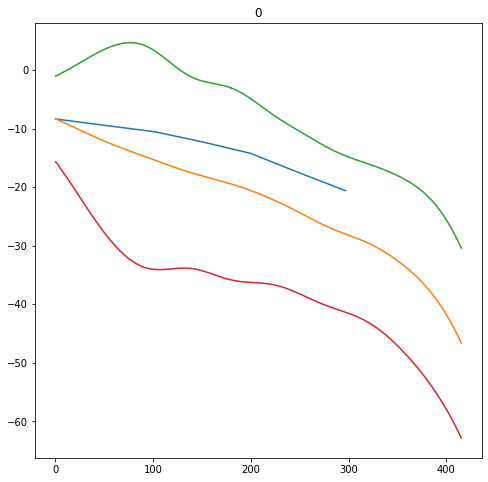

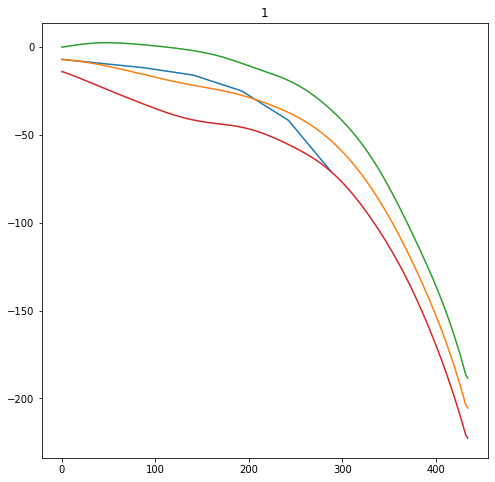

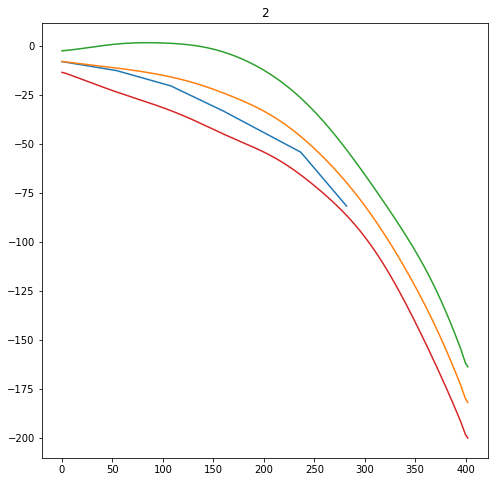

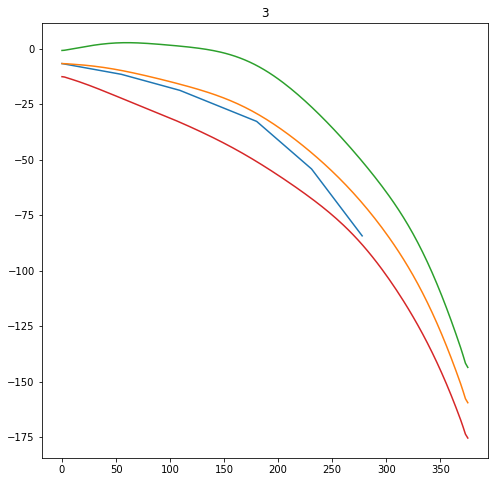

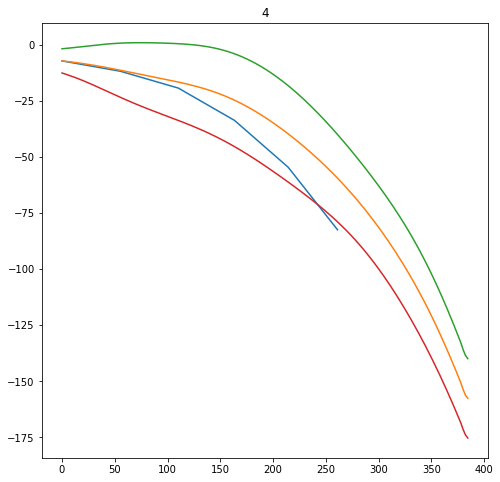

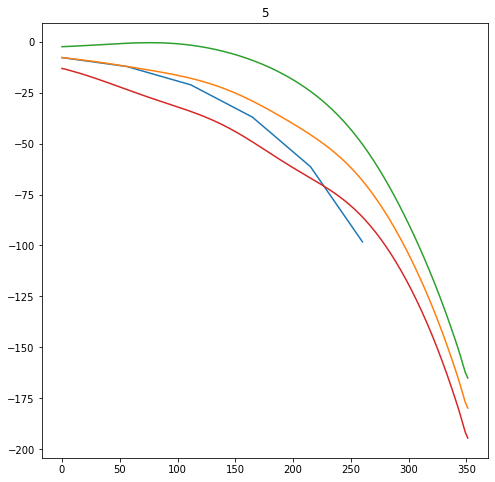

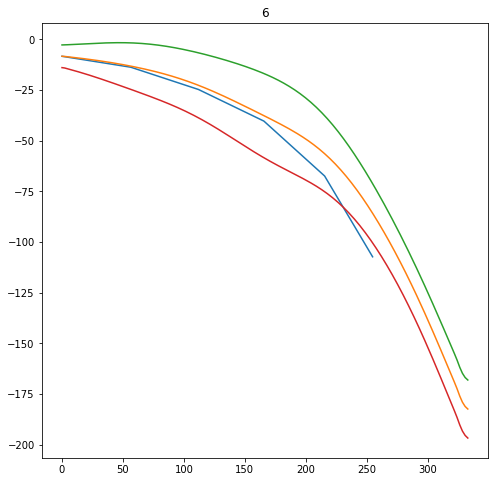

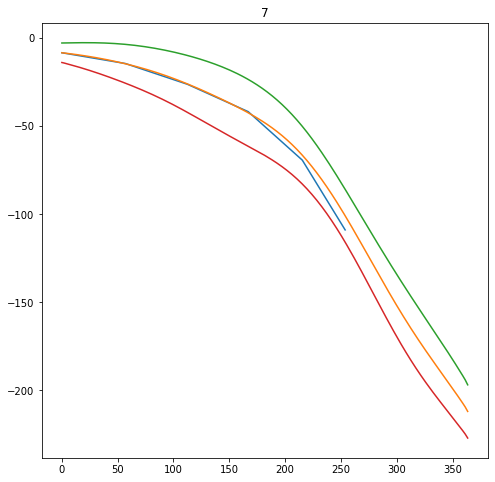

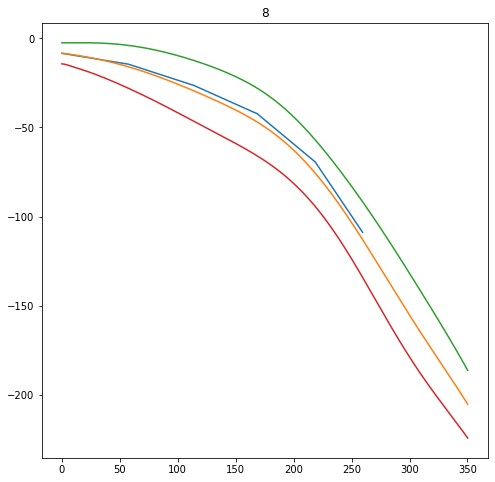

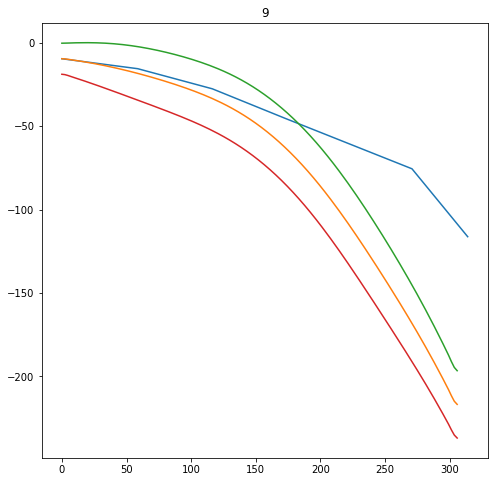

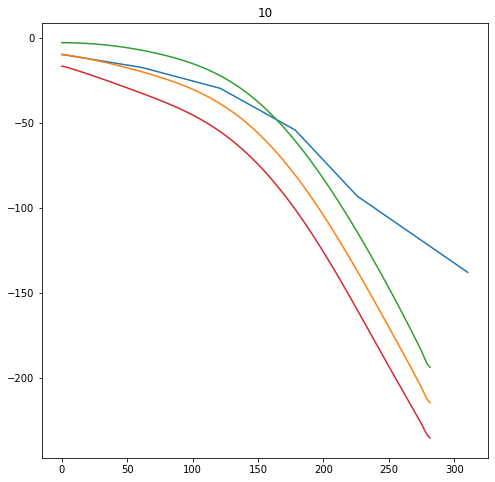

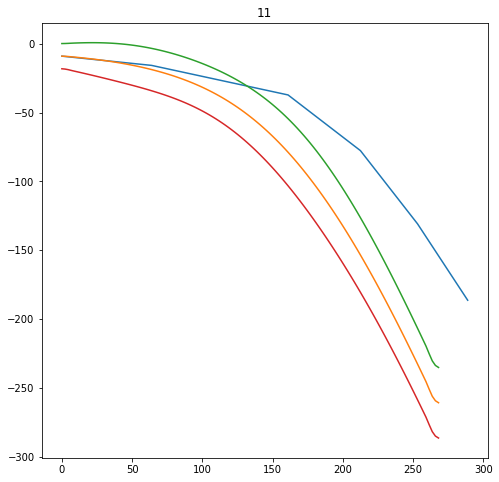

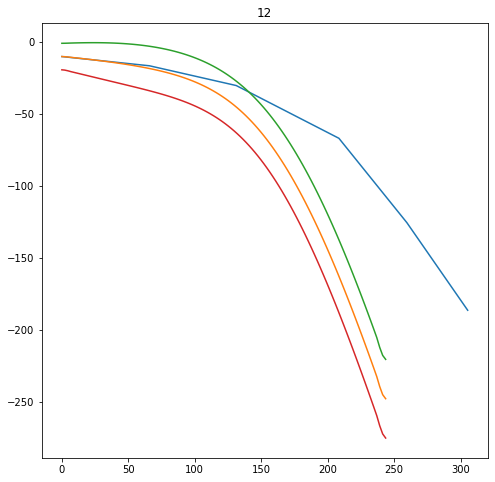

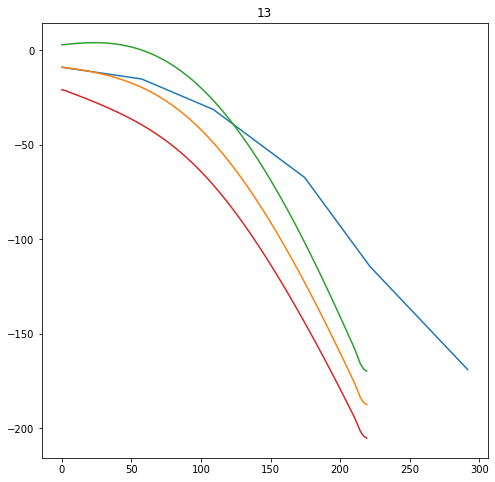

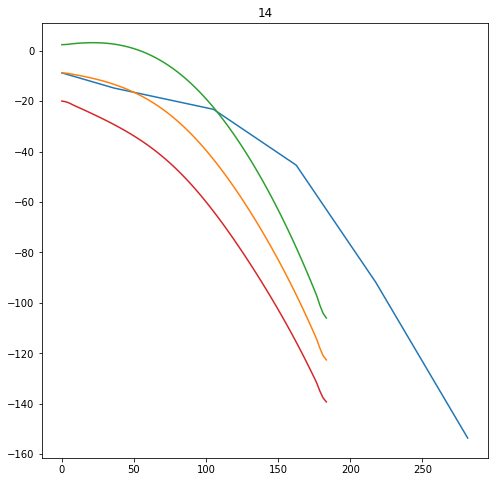

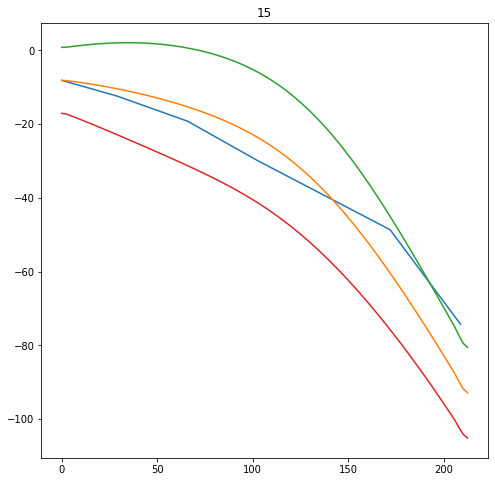

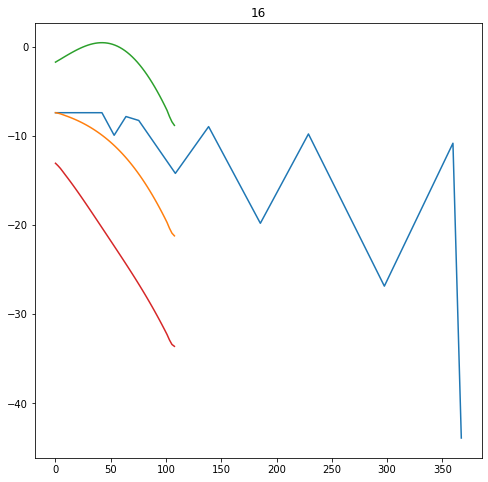

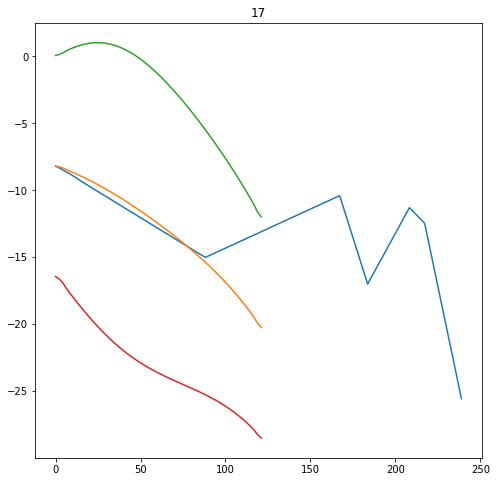

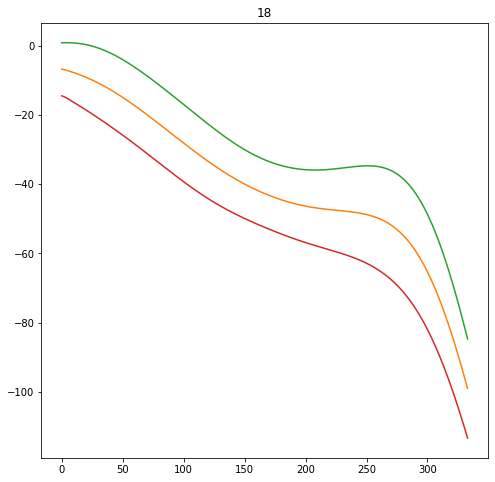

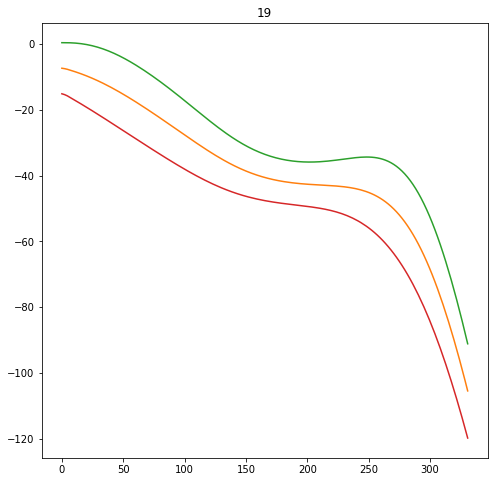

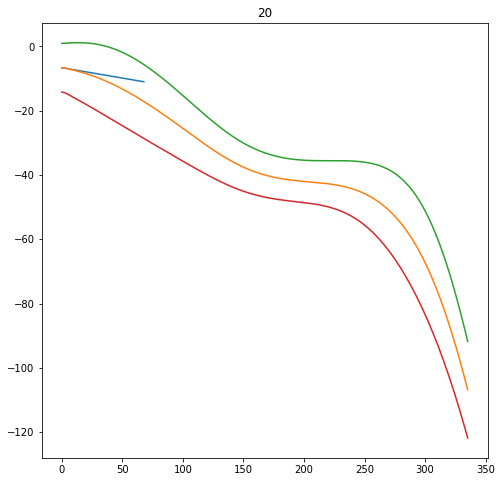

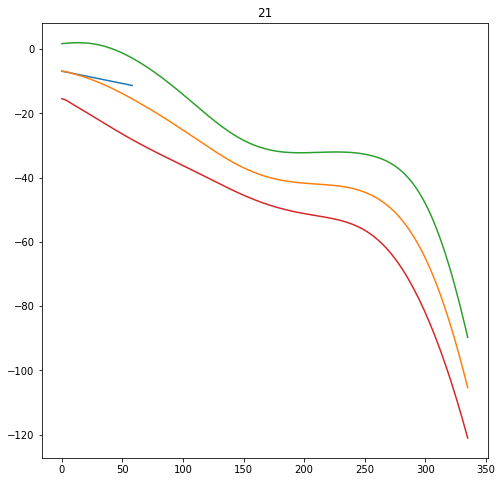

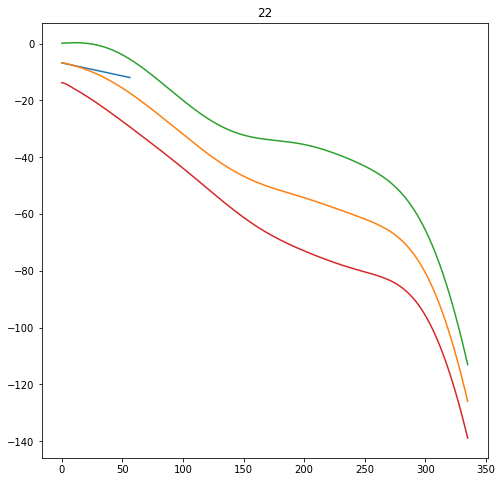

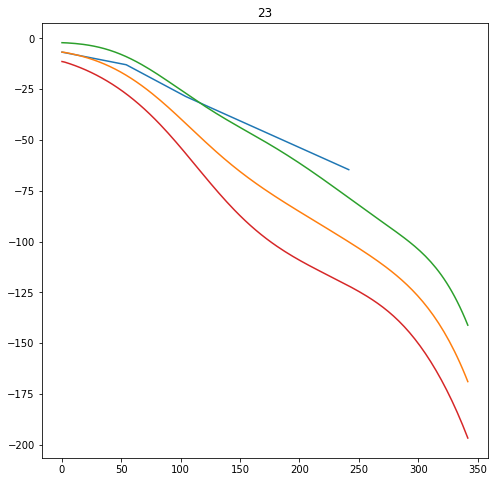

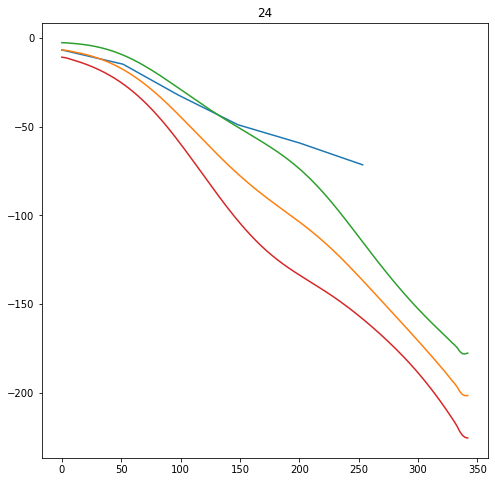

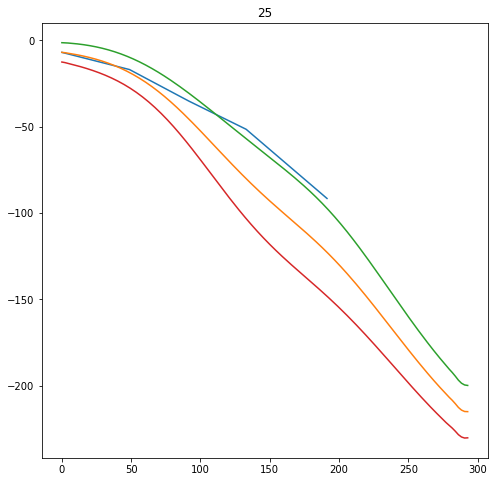

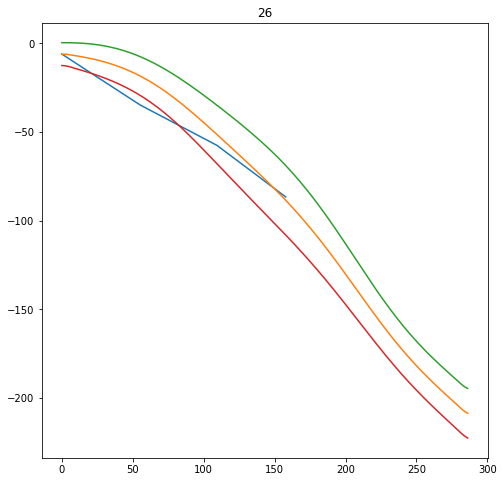

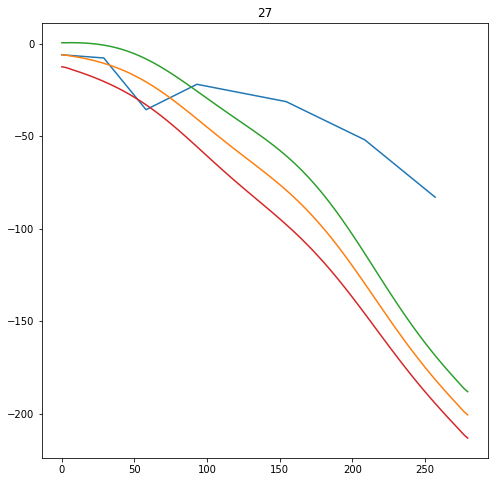

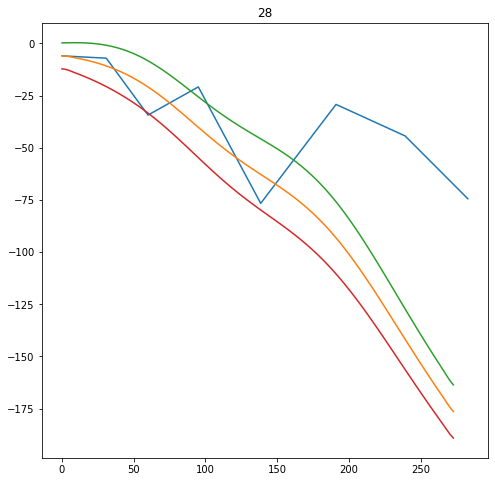

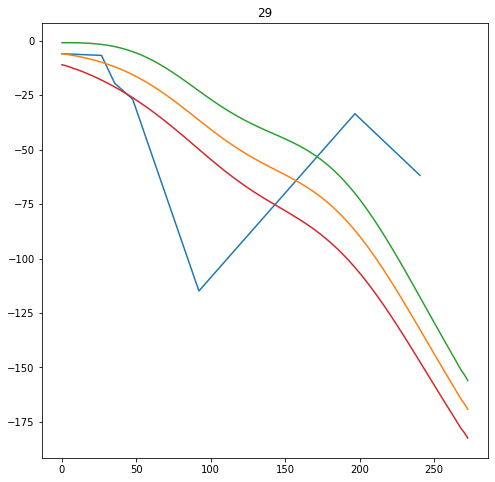

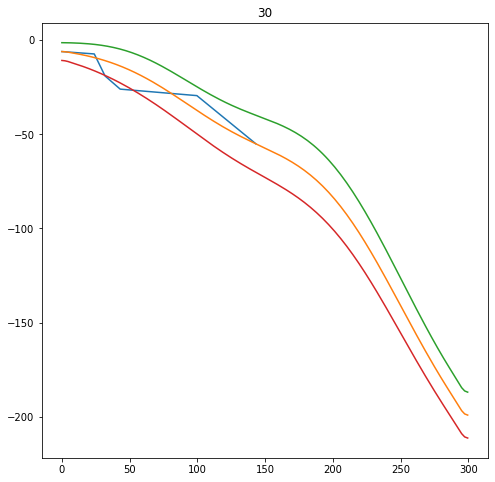

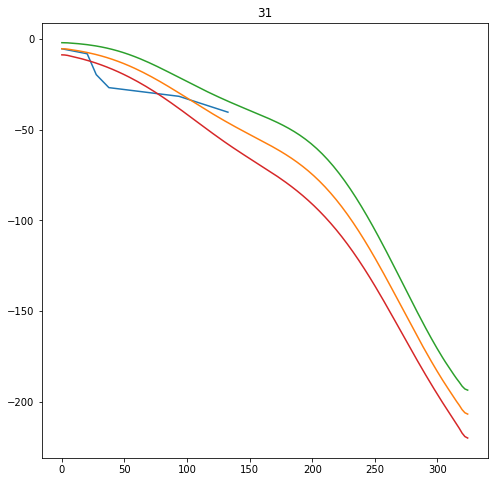

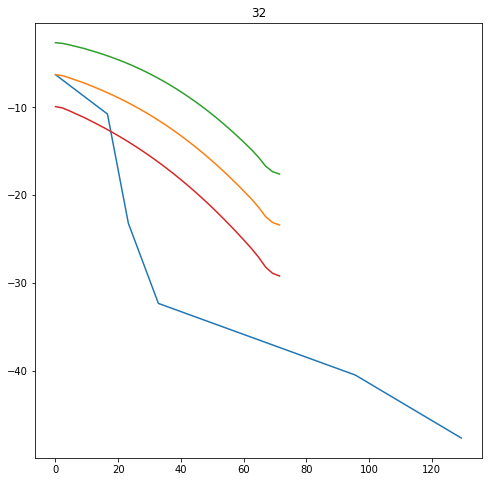

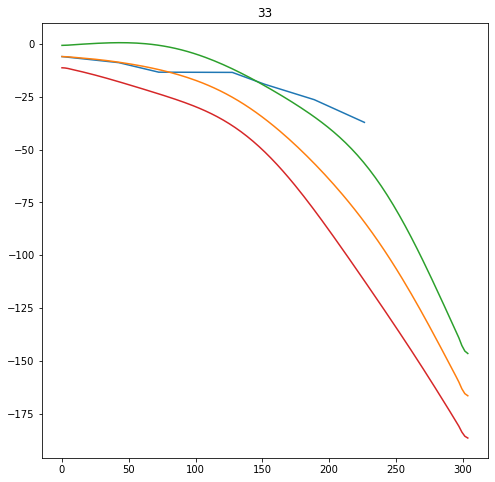

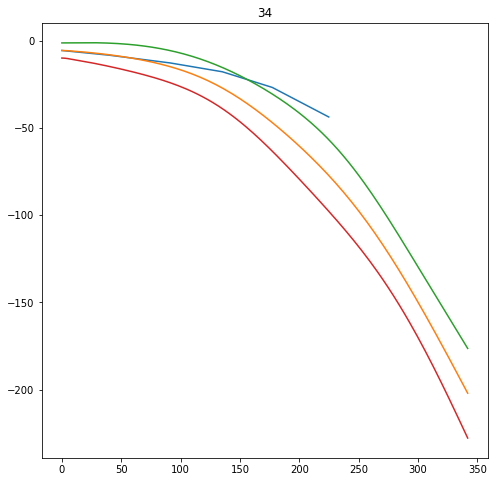

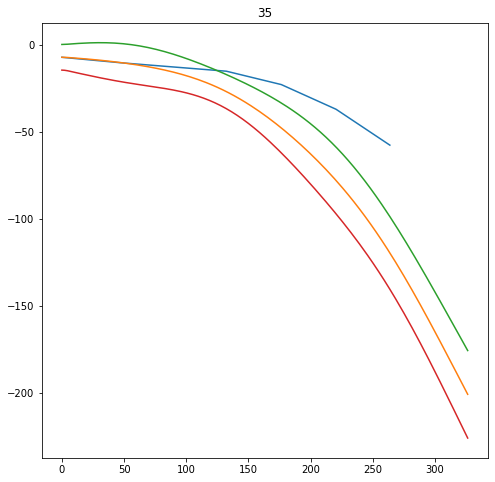

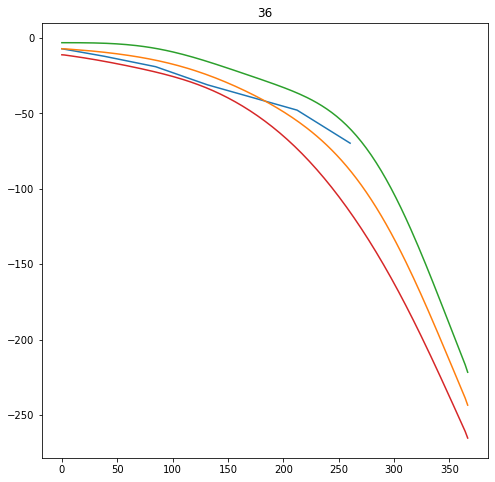

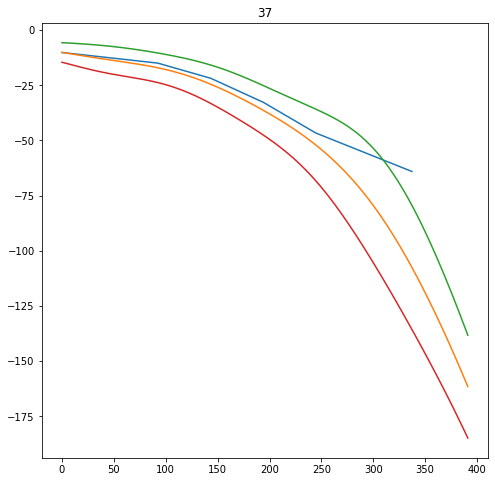

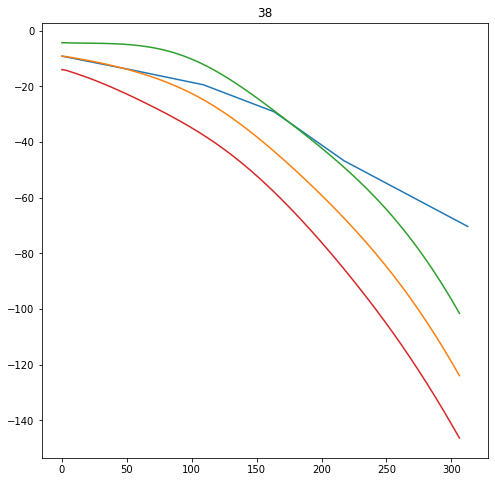

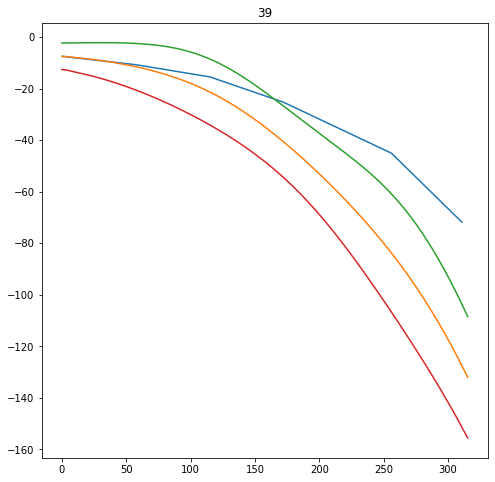

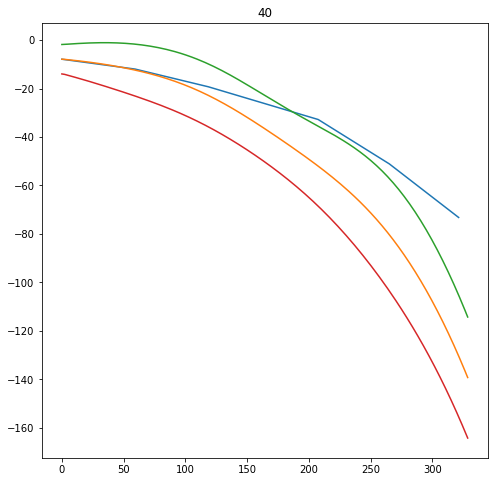

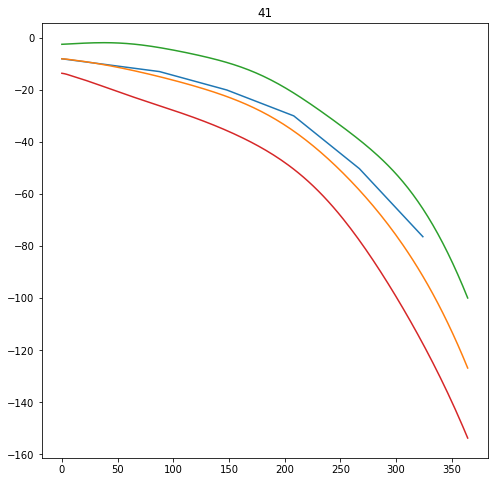

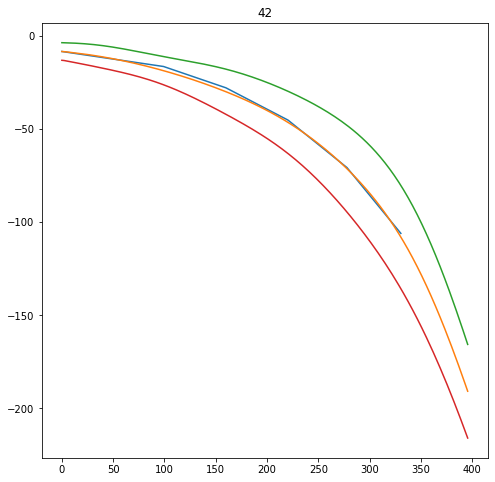

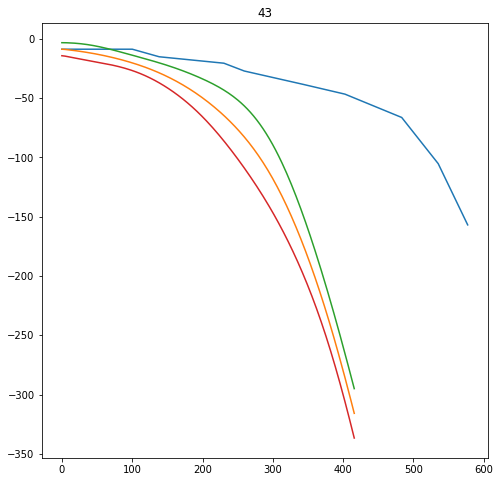

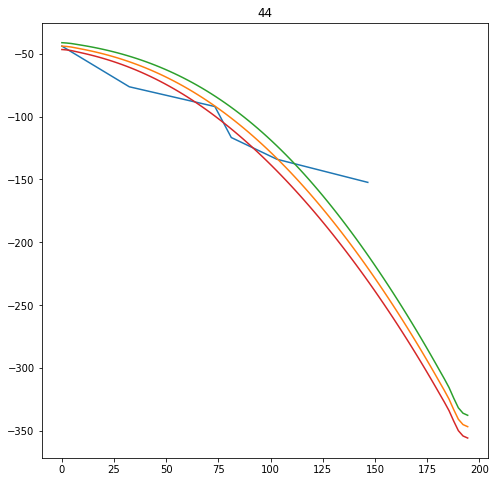

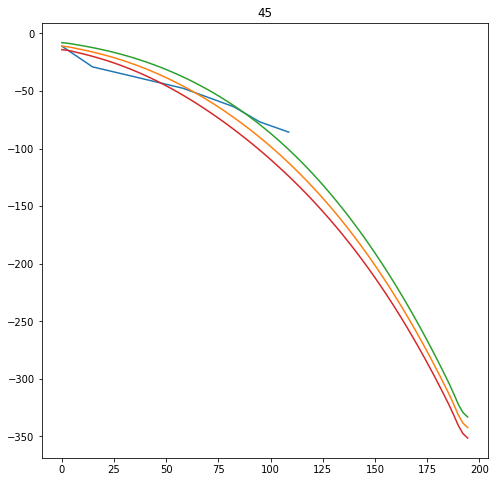

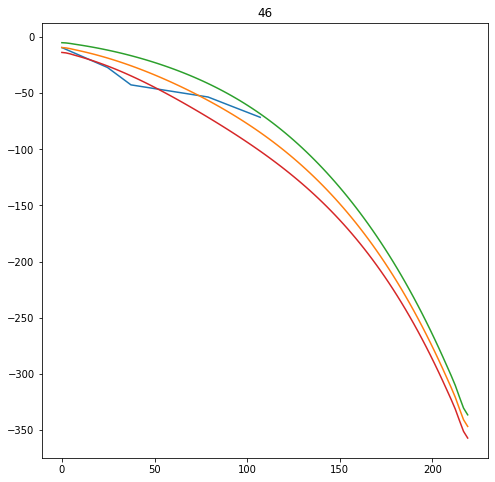

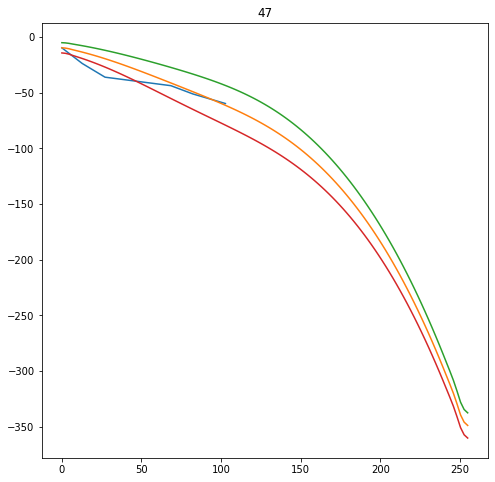

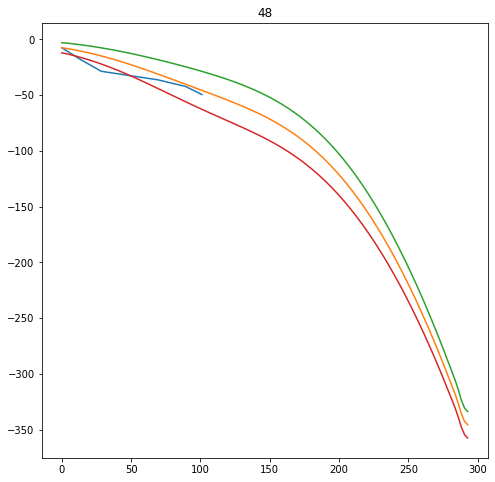

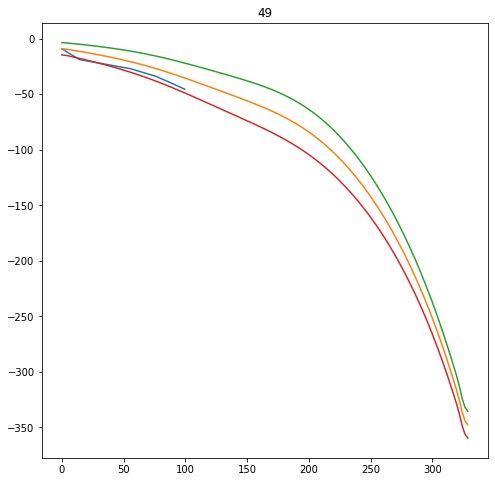

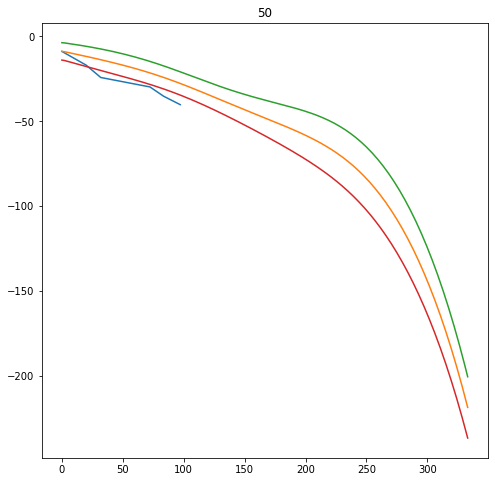

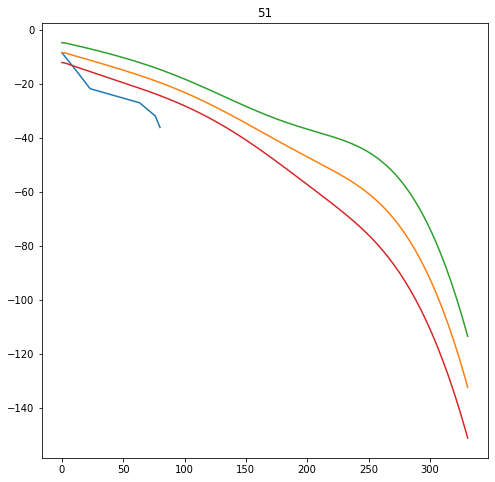

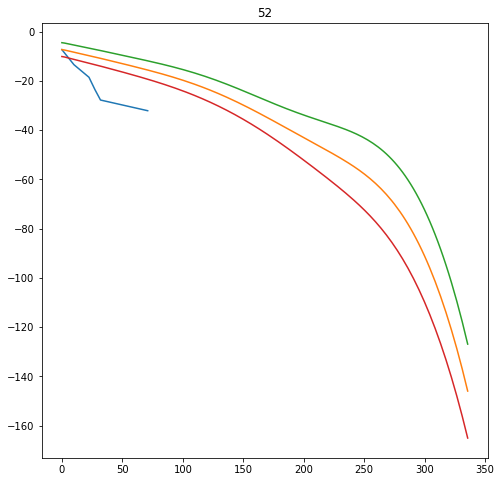

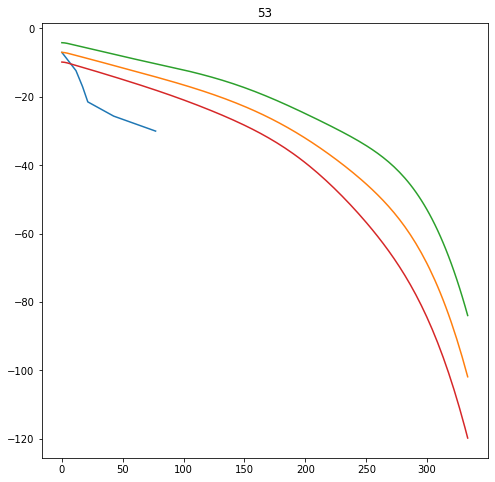

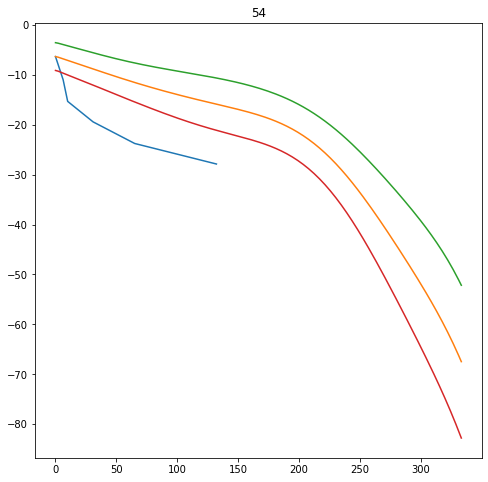

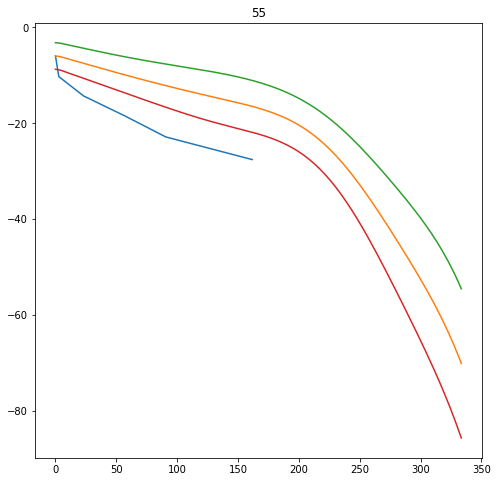

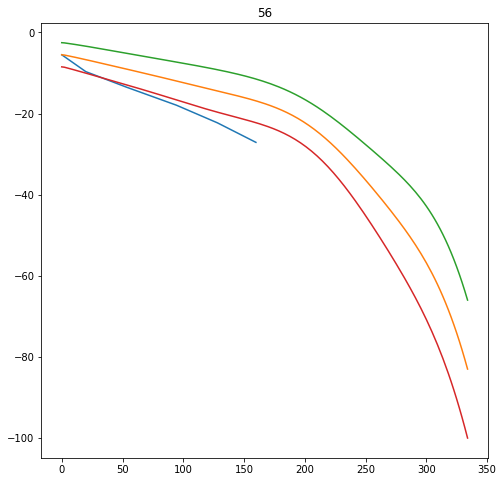

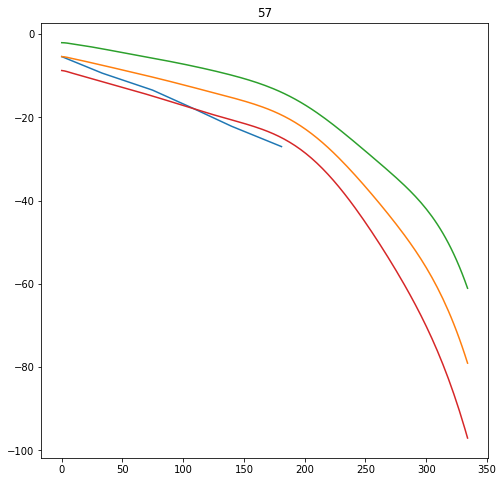

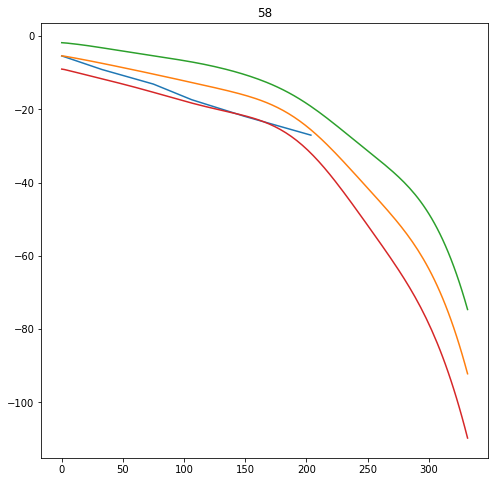

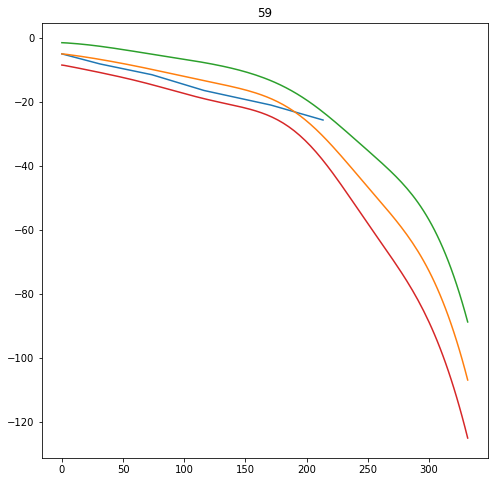

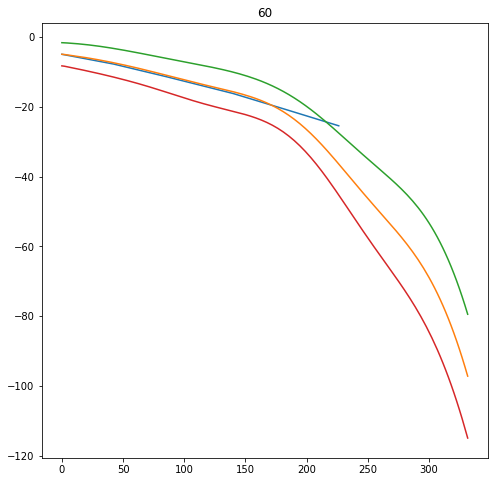

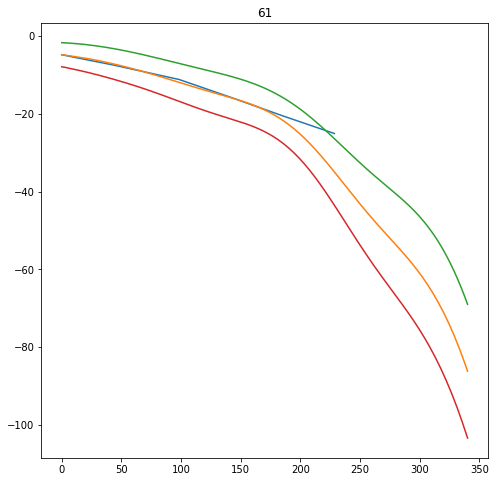

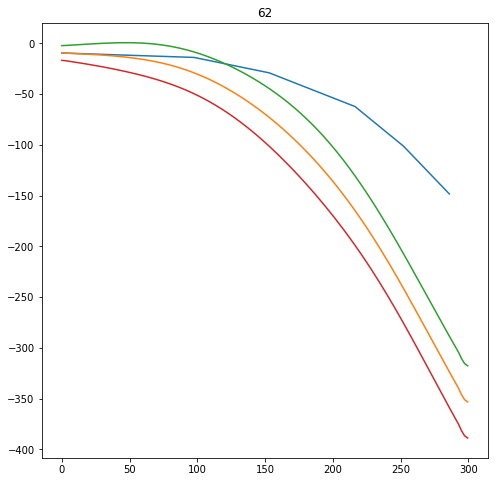

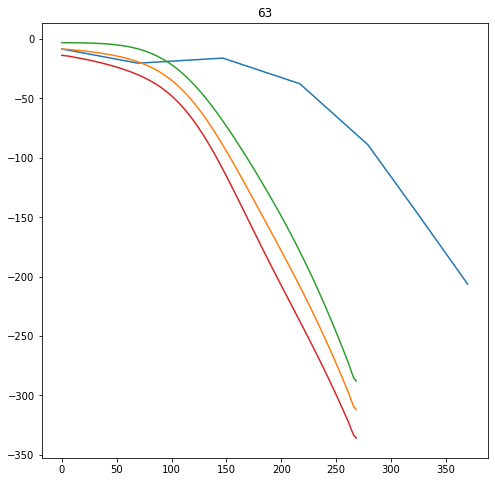

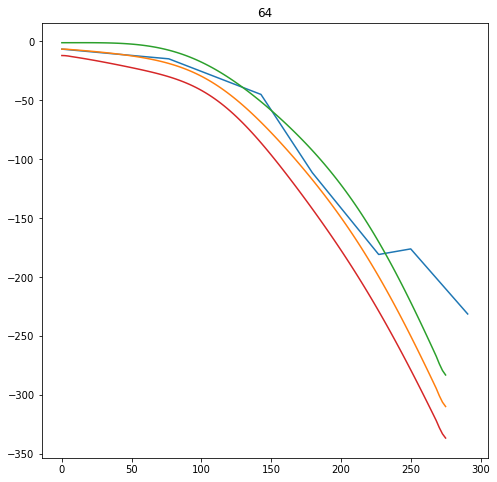

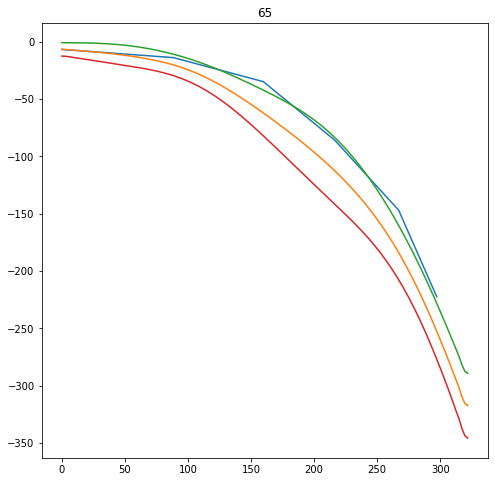

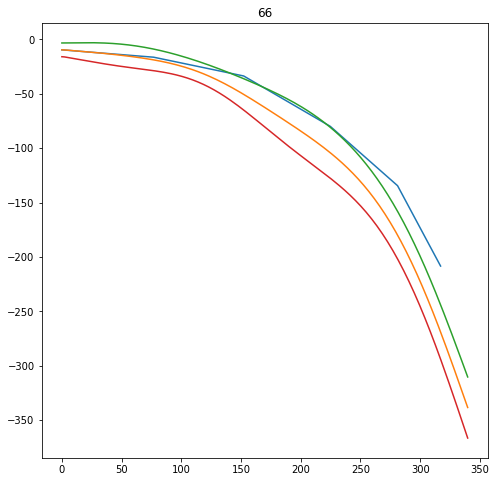

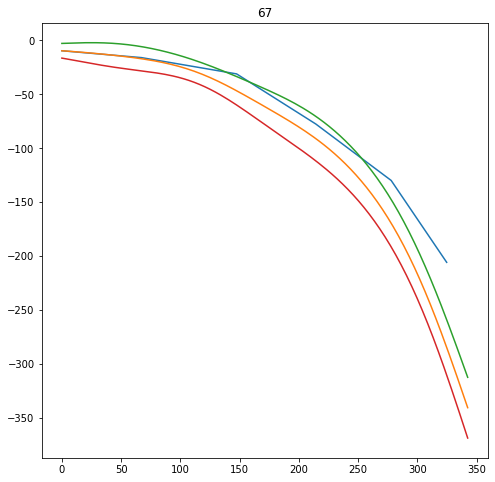

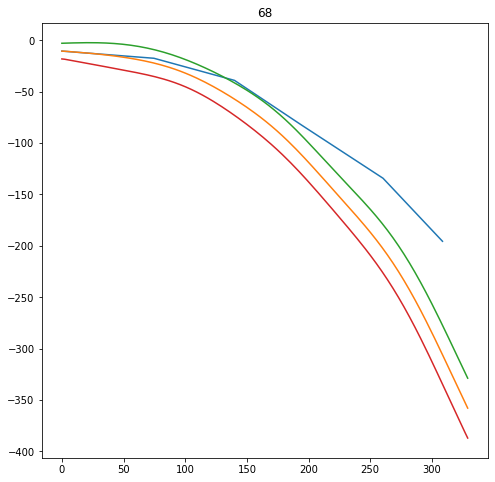

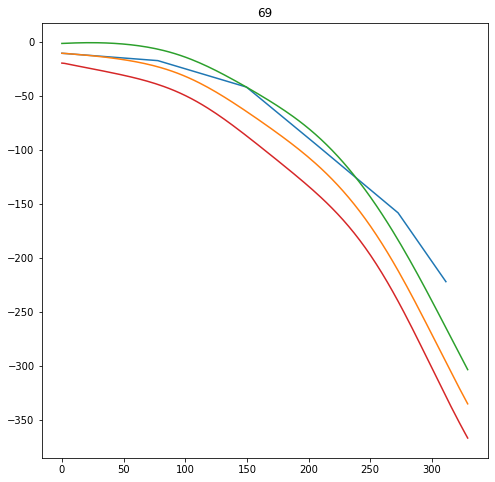

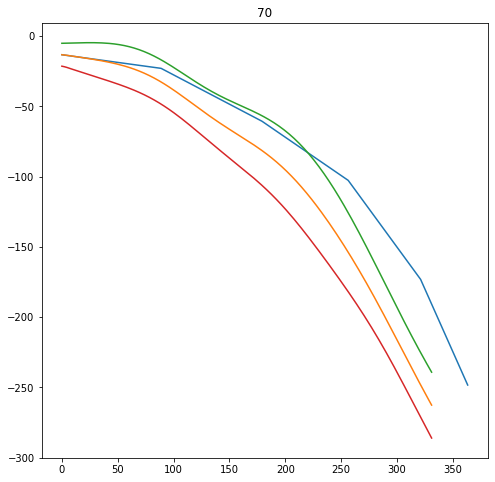

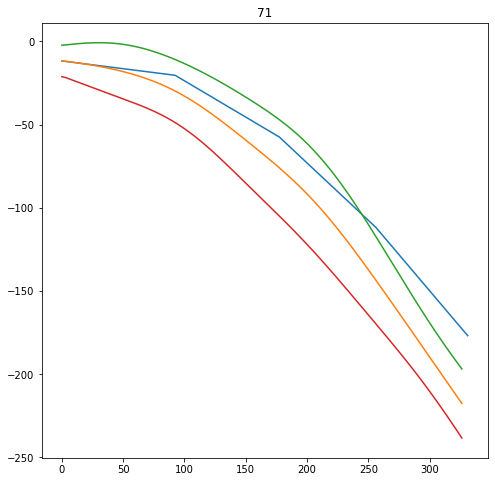

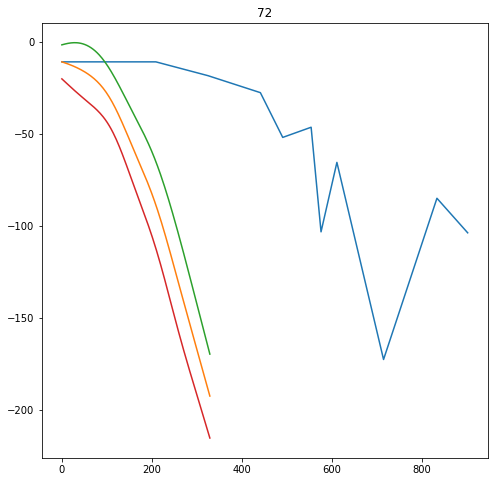

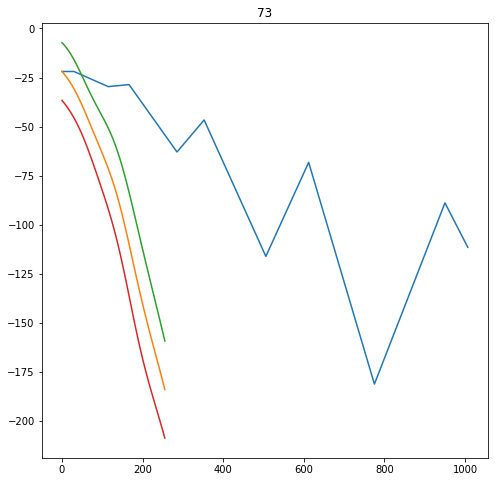

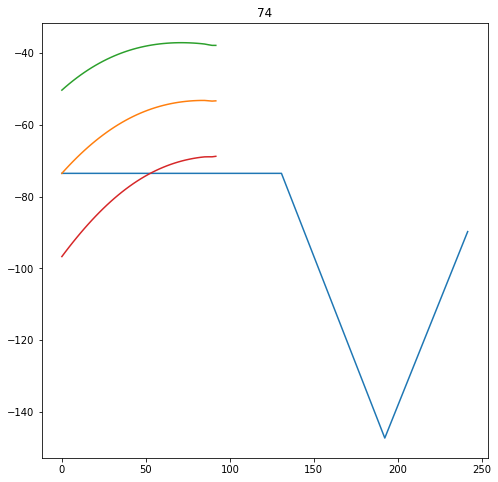

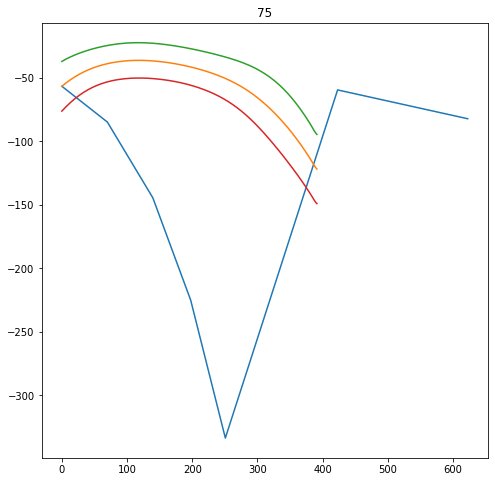

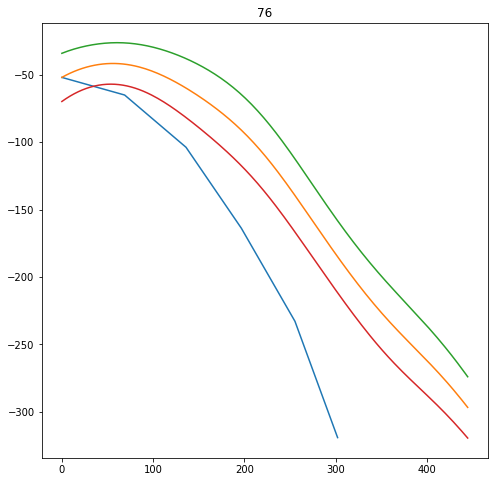

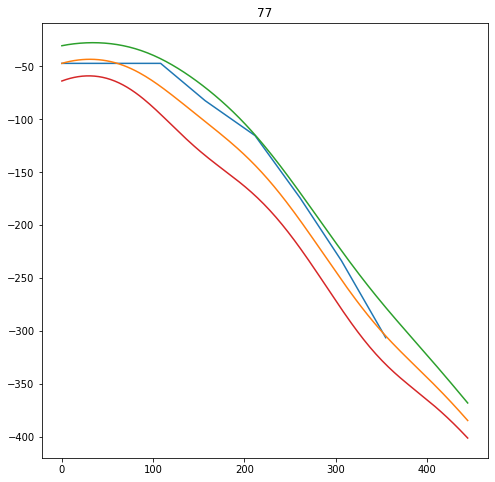

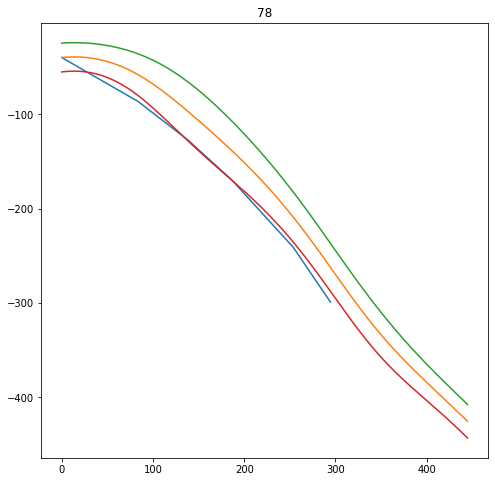

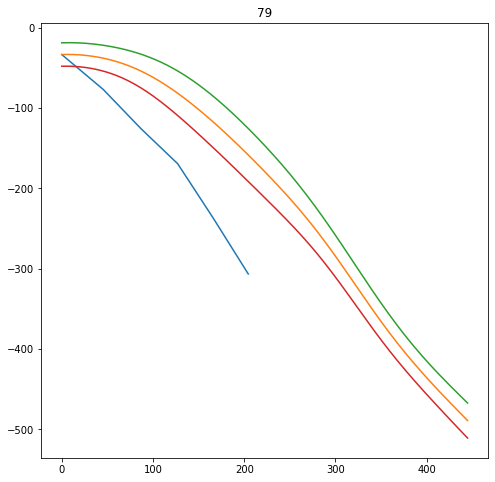

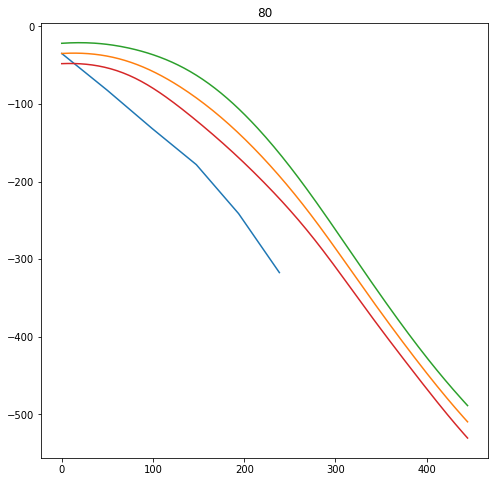

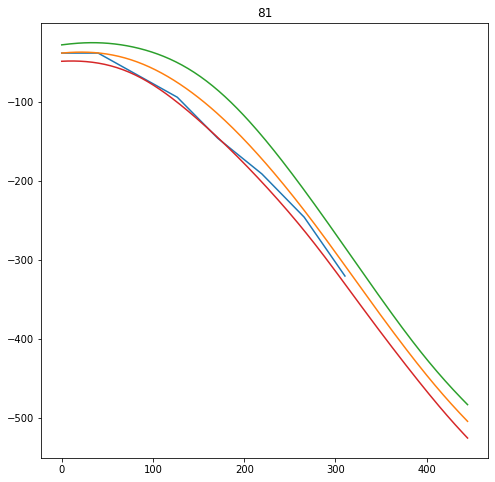

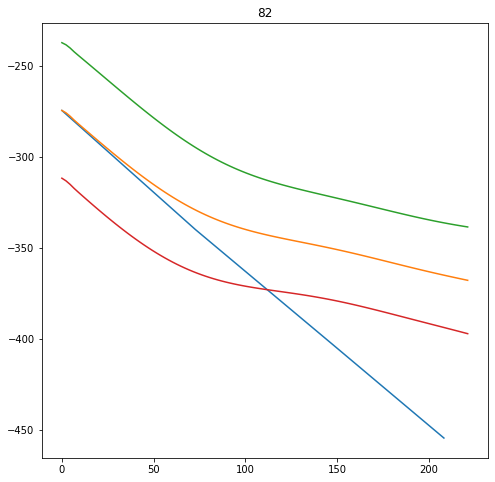

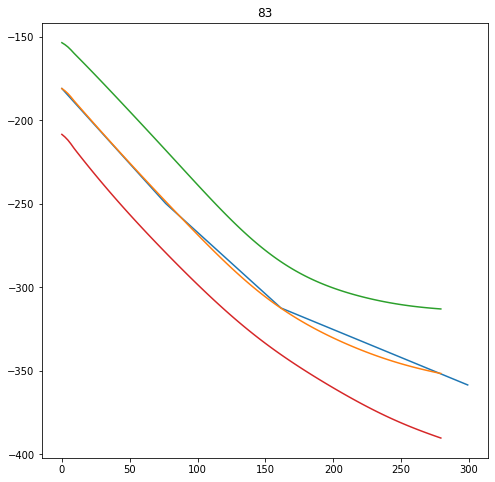

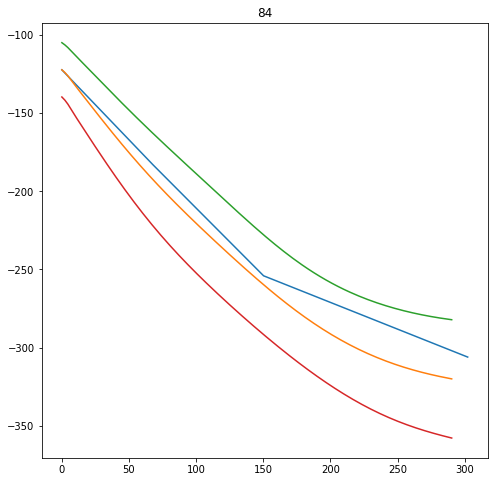

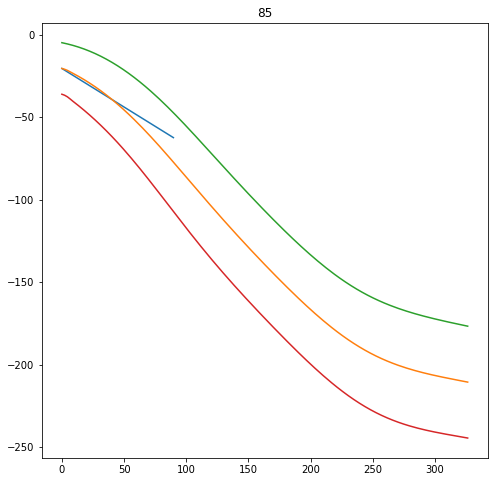

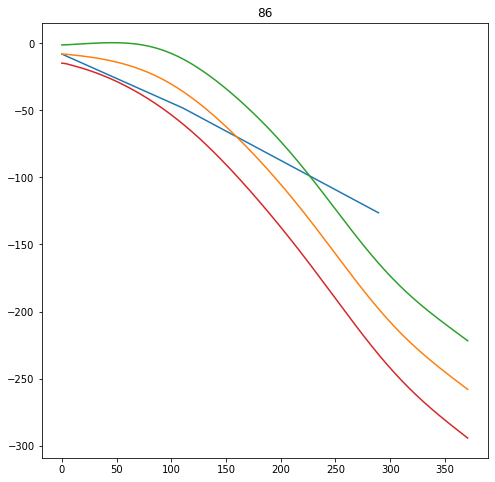

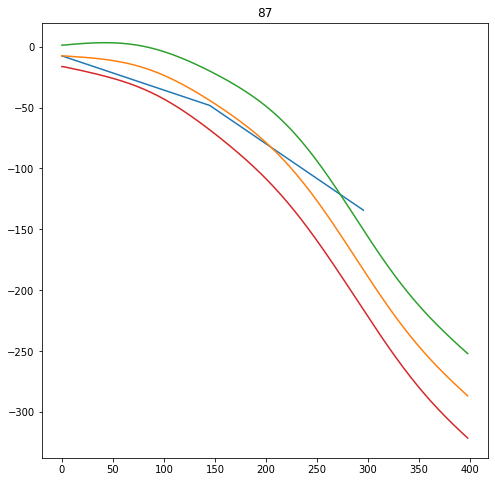

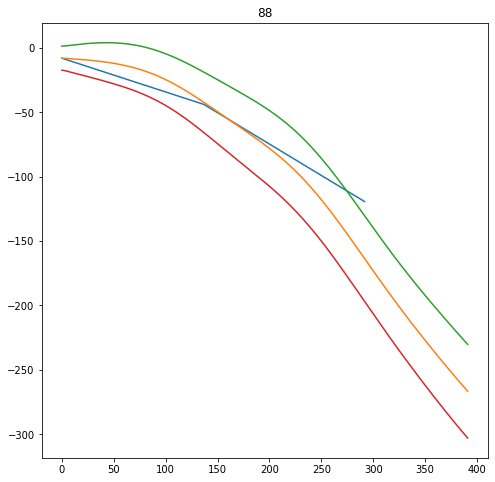

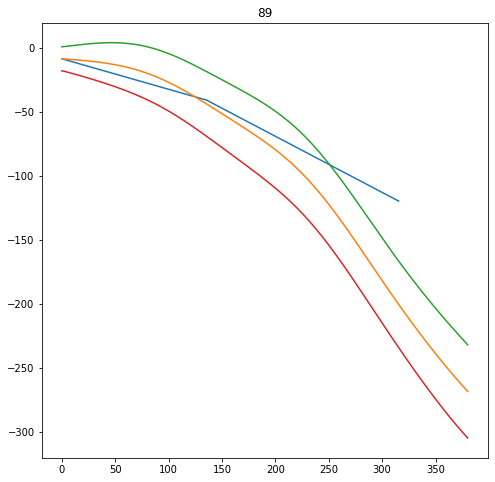

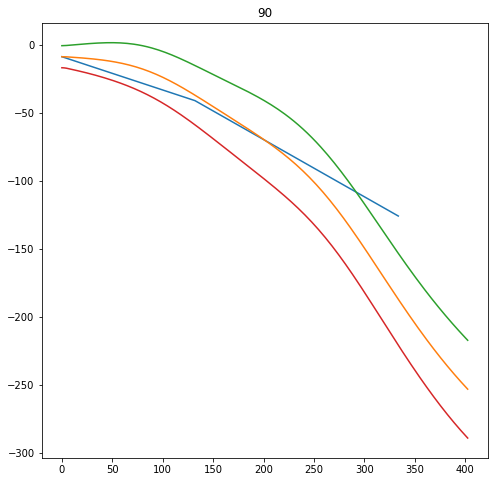

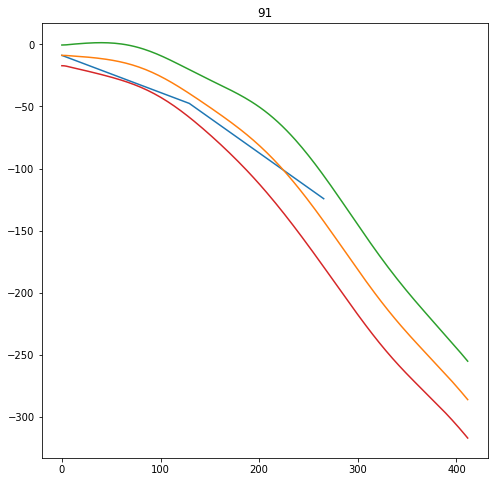

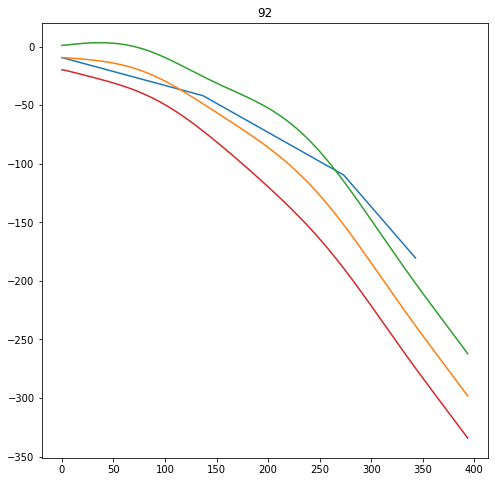

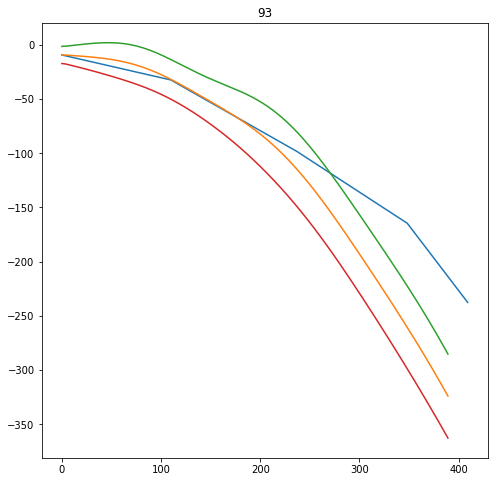

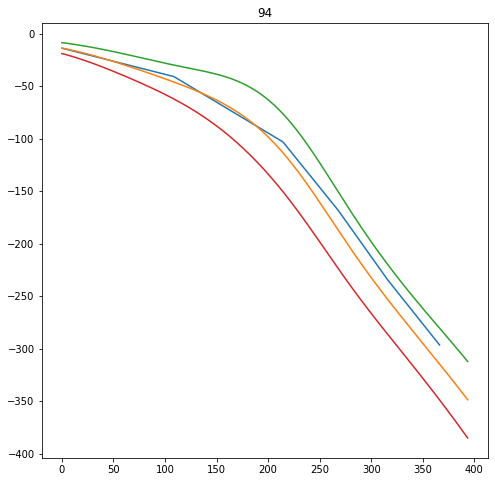

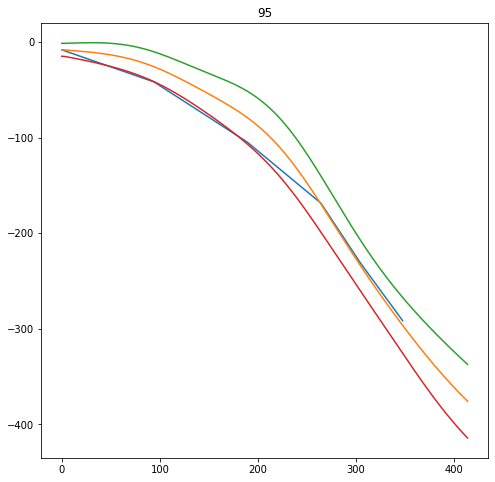

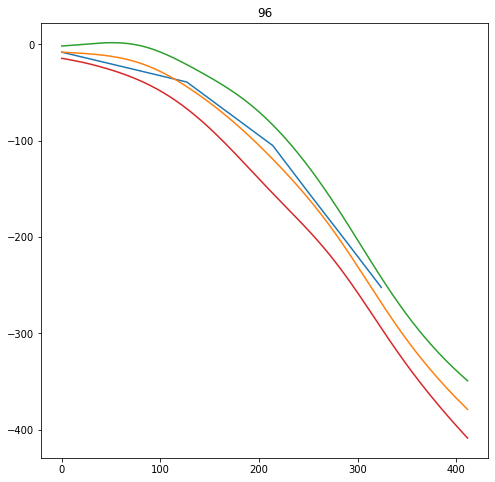

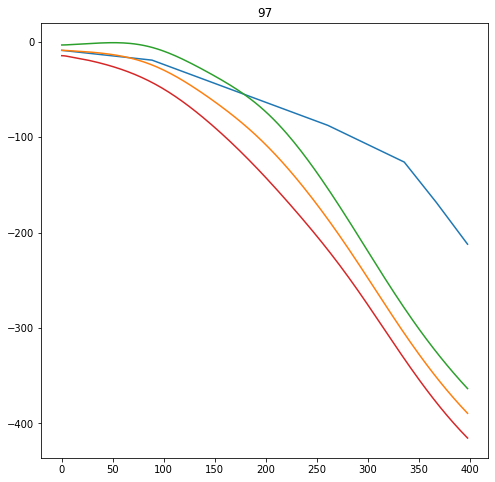

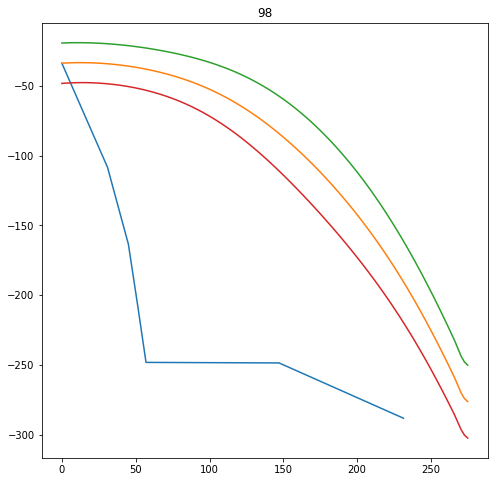

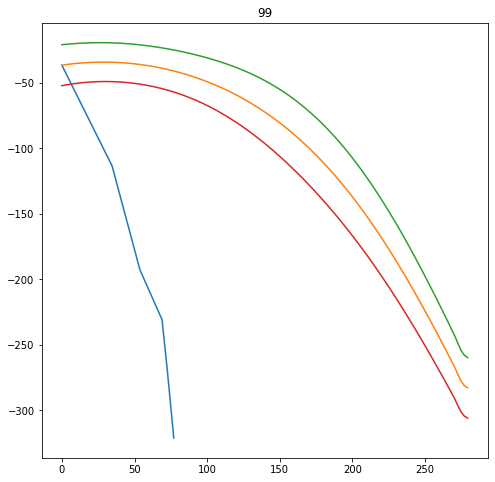

In [12]:
for tracks_ind,i in enumerate(tracks[:100]):
    temp_distances_tracks = []
    for ind, (row_ind, row) in enumerate(tracks[tracks_ind].iterrows()):
        #print(ind)
        if ind == 0:
            #print(ind)
            temp_distances_tracks.append(0)
        else:
            #print('h',ind)
            #print(tracks[-100]['lon'].values[ind-1])
            lon1 = tracks[tracks_ind]['lon'].values[ind-1]
            lat1 = tracks[tracks_ind]['lat'].values[ind-1]
            lon2 = row['lon']
            lat2 = row['lat']

            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
            dlon = lon2 - lon1
            dlat = lat2 - lat1 

            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

            c = 2 * np.arcsin(np.sqrt(a)) 
            r = 6371 # Radius of earth in kilometers. Use 3956 for miles

            distance = c*r
            temp_distances_tracks.append(distance + temp_distances_tracks[ind-1])
    #temp_distances.reverse()
    temp_lats = []
    temp_lons = []
    temp_distances = []
    for ind, i in enumerate(intersecting_points[tracks_ind]):

        if ind == 0:
            #print(ind)
            temp_distances.append(0)
        else:
            #print('h',ind)
            lon1 = intersecting_points[tracks_ind][ind-1][1].to_lat_lon_array()[0][1]
            lat1 = intersecting_points[tracks_ind][ind-1][1].to_lat_lon_array()[0][0]
            lon2 = intersecting_points[tracks_ind][ind][1].to_lat_lon_array()[0][1]
            lat2 = intersecting_points[tracks_ind][ind][1].to_lat_lon_array()[0][0]

            lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
            dlon = lon2 - lon1
            dlat = lat2 - lat1 

            a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2

            c = 2 * np.arcsin(np.sqrt(a)) 
            r = 6371 # Radius of earth in kilometers. Use 3956 for miles

            distance = c*r
            temp_distances.append(distance + temp_distances[ind-1])

    temp_distances.reverse()
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
    ax.plot(temp_distances, [i*-1-tracks[tracks_ind]['depth'].values[0] for i in intersecting_depths[tracks_ind]])
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1)
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1+tracks[tracks_ind]['depth_uncertainty'])
    ax.plot(temp_distances_tracks,tracks[tracks_ind]['depth']*-1-tracks[tracks_ind]['depth_uncertainty'])
    ax.set_title(tracks_ind)

In [25]:
cross_section_lines[test_index].to_lat_lon_array()[:][:,0]

array([20.20970647, 20.22086177, 20.23195358, 20.24298185, 20.25394654,
       20.26484759, 20.27568496, 20.28645861, 20.29716849, 20.30781455,
       20.31839675, 20.32891504, 20.33936939, 20.34975974, 20.36008605,
       20.37034827, 20.38054637, 20.3906803 , 20.40075001, 20.41075547,
       20.42069663, 20.43057345, 20.44038588, 20.45013388, 20.45981742,
       20.46943645, 20.47899093, 20.48848082, 20.49790607, 20.50726666,
       20.51656253, 20.52579365, 20.53495997, 20.54406147, 20.5530981 ,
       20.56206981, 20.57097658, 20.57981836, 20.58859512, 20.59730682,
       20.60595342])

In [24]:
cross_section_lines[test_index].to_lat_lon_array()[:][:,1]+360

array([253.13467337, 253.24057251, 253.3464868 , 253.45241617,
       253.55836052, 253.6643198 , 253.77029393, 253.87628282,
       253.9822864 , 254.0883046 , 254.19433733, 254.30038452,
       254.4064461 , 254.51252198, 254.61861209, 254.72471634,
       254.83083467, 254.93696698, 255.04311321, 255.14927327,
       255.25544709, 255.36163457, 255.46783566, 255.57405025,
       255.68027828, 255.78651966, 255.89277431, 255.99904216,
       256.10532311, 256.21161709, 256.31792402, 256.42424381,
       256.53057638, 256.63692166, 256.74327955, 256.84964997,
       256.95603285, 257.0624281 , 257.16883563, 257.27525536,
       257.38168721])

(250.0, 260.0)

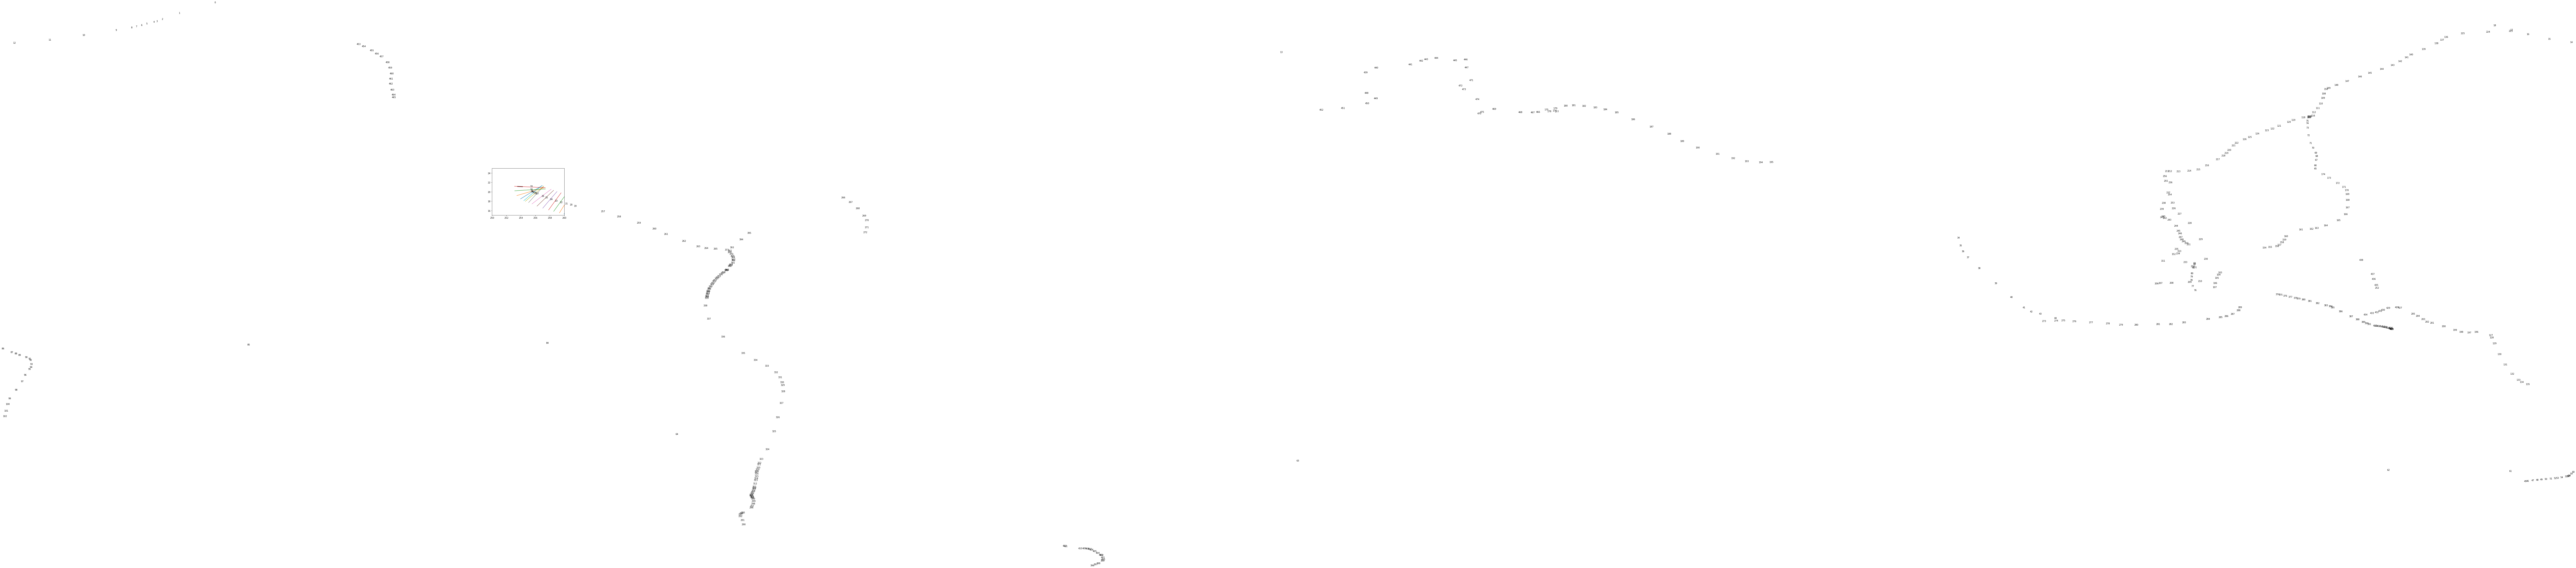

In [41]:
plt.plot(tracks[test_index]['lon'].values,
        tracks[test_index]['lat'].values, c='k', lw=3)
for ind, i in enumerate(cross_section_lines):
    plt.plot(i.to_lat_lon_array()[:][:,1]+360,
             i.to_lat_lon_array()[:][:,0])
    plt.text(np.mean(i.to_lat_lon_array()[:][:,1]+360),
             np.mean(i.to_lat_lon_array()[:][:,0]),
             ind)

plt.ylim(15,25)
plt.xlim(250, 260)

In [13]:
test_index = 32
test_lat = []
test_lon = []
for i in intersecting_points[test_index]:
    test_lon.append(i[1].to_lat_lon_array()[0][1])
    test_lat.append(i[1].to_lat_lon_array()[0][0])

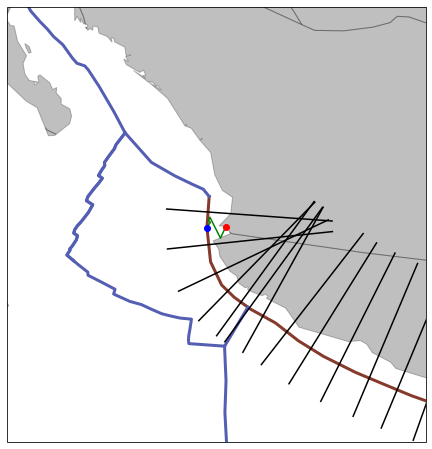

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8),
                     subplot_kw={'projection': ccrs.Orthographic(np.mean(test_lon),
                                                                 np.mean(test_lat))})
#fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8),
#                     subplot_kw={'projection': ccrs.Robinson()})

date_line_wrapper = pygplates.DateLineWrapper(0)
data_crs = ccrs.Geodetic()
poly_data_crs = ccrs.PlateCarree()
for i in cross_section_lines:
    start_point = i.to_lat_lon_array()[0]
    end_point = i.to_lat_lon_array()[-1]
    #print(i.to_lat_lon_array()[0], i.to_lat_lon_array()[-1])
    ax.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]],
            c='k',
            zorder=3,
            transform=data_crs)

reconstructed_polygons = []

pygplates.reconstruct(coastlines,rotation_model, reconstructed_polygons, int(time))
for polygon in reconstructed_polygons:
    poly_geom = pygplates.PolygonOnSphere(polygon.get_reconstructed_geometry())
    wrapped_polys = date_line_wrapper.wrap(poly_geom, 1)
    for wrapped_poly in wrapped_polys:
        wrapped_poly_lat = []
        wrapped_poly_lon = []
        for wrapped_poly_point in wrapped_poly.get_exterior_points():
            wrapped_poly_lat.append(wrapped_poly_point.get_latitude())
            wrapped_poly_lon.append(wrapped_poly_point.get_longitude())

        ax.fill(wrapped_poly_lon, wrapped_poly_lat, color='k', alpha=0.25,
                linewidth=1 ,zorder=1, transform=poly_data_crs)

for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_mid_ocean_ridge:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=1, zorder=2, transform=data_crs)

    elif shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=1, zorder=2, transform=data_crs)                
    else:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                ax.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='k',
                        linewidth=1, alpha=1, zorder=2, transform=data_crs)

gl = ax.gridlines()
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])
#ax.scatter(134, 31, c='green', s=100,transform=poly_data_crs, zorder=4)
ax.plot(test_lon, test_lat, c='green',transform=data_crs, zorder=4)
#extent=[longitude_top_left,longitude_top_right,latitude_bottom_left,latitude_top_left].
ax.set_extent([np.min(test_lon)-5, np.max(test_lon)+5, np.min(test_lat)-5, np.max(test_lat)+5],
              crs=ccrs.PlateCarree())
ax.scatter(test_lon[0], test_lat[0], c='blue', transform=poly_data_crs, zorder=5)
ax.scatter(test_lon[-1], test_lat[-1], c='red', transform=poly_data_crs, zorder=5)
#ax.set_global()
#fig.savefig('/Users/andrew/Documents/Manuscripts/Merdith_2021_serpentinite_sub_zones/cross_sections.pdf')

In [15]:
intersecting_points[test_index][0][1].to_lat_lon_array()

array([[  20.73162895, -105.85241416]])

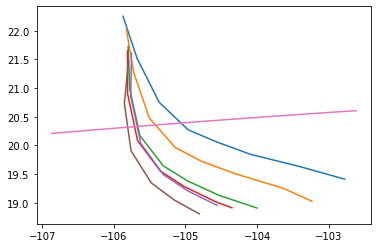

In [16]:
for i in intersecting_lines[test_index]:
#    print(i[1])
    plt.plot(i[1].to_lat_lon_array()[:,1],
             i[1].to_lat_lon_array()[:,0])
    
plt.plot(cross_section_lines[test_index].to_lat_lon_array()[:,1],
         cross_section_lines[test_index].to_lat_lon_array()[:,0])

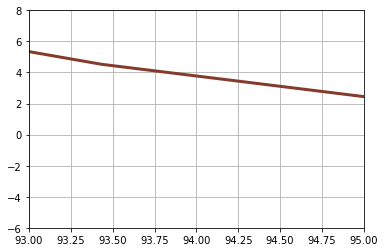

In [17]:
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                plt.plot(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#853a2b',
                        linewidth=3, alpha=1, zorder=2)
                
for i in intersecting_lines[test_index]:
    #print(i[0], i[-1])
#    print(i[1])
    plt.plot(i[1].to_lat_lon_array()[:,1],
             i[1].to_lat_lon_array()[:,0])
    
plt.plot(cross_section_lines[test_index].to_lat_lon_array()[:,1],
         cross_section_lines[test_index].to_lat_lon_array()[:,0])

plt.xlim(93,95)
plt.ylim(-6,8)
plt.grid()

In [ ]:
output_data[test_index]

In [ ]:
intersecting_lines[test_index]

In [ ]:
test_lat = []
test_lon = []
for i in intersecting_points[14]:
    test_lon.append(i[1].to_lat_lon_array()[0][1])
    test_lat.append(i[1].to_lat_lon_array()[0][0])

In [ ]:
#define line for cross section
#we need two types of cross sections, one for slab 2.0
#one for pygmt
#they, unfortunately, have to be built in different ways

#slab2.0
lat1 = key[0]
lon1 = key[2]
lat2 = key[1]
lon2 = key[3]
cross_section_line = slab_workflow.cross_section_line_pygplates(lat1,lon1,lat2,lon2,0.1)

#get the iso-subchrons that intersect the cross section line

intersecting_lines = []
for ind, polyline in enumerate(output_data):
    
    #get min distance between 'iso-sub-chron' and our cross section
    min_distance_to_feature = pygplates.GeometryOnSphere.distance(polyline[1],cross_section_line)
    #if min distance is 0, then they intersect and we want the rest of the data
    if min_distance_to_feature == 0:
        intersecting_lines.append(polyline)
        

steps = 200
lat = np.linspace(lat1,lat2, int(steps))
lon = np.linspace(lon1,lon2, int(steps))
#pygmt track needs lon/lat as separate columns in pandas dataframe
d = { 'lon': lon,'lat': lat}
points = pd.DataFrame(data=d)



In [ ]:
###main calculation, get data from cross sections

# Sample the sub zone using grdtrack. It returns a dataframe with a new column and the results
track = pygmt.grdtrack(points=points, grid=grid, newcolname='depth')
track_uncertain = pygmt.grdtrack(points=points, grid=grid_uncertainty, newcolname='depth_uncertainty')
#the df will contain some NaNs that we want to filter
track_dropna = track.dropna()
track_uncertain_dropna = track_uncertain.dropna()
#our data so far
track_dropna['depth'] = track_dropna['depth'] * -0.001

track_uncertain_dropna['depth_uncertainty'] = track_uncertain_dropna['depth_uncertainty'] * 0.001
#get points intersecting the cross section from slab 2.0
intersecting_points_reversed, intersecting_points, interpolated_variables, interpolated_depths = get_intersecting_values(intersecting_lines, cross_section_line)

In [ ]:
interpolated_variables

In [ ]:
intersecting_points_reversed[0][1].to_lat_lon_array()

In [ ]:
intersecting_points

In [ ]:
#pressure tests

In [ ]:
#assume 30 km for continenta crust?
density = np.ones_like(depth)
continental_curst_rho = 2.83
mantle_rho = 3.3

for ind,i in enumerate(depth):
    if i <=30:
        density[ind] = continental_curst_rho
    else:
        density[ind] = mantle_rho
        

In [ ]:
def calcualte_pressure(density, depth):
    
    '''
    Calculate pressure at a series of points of set depths (km) with designated densities (g/cm3). Assumes 
    gravity is constant (9.8 m/s**2).

    The basic equation we use is:

    pressure = density • gravity • depth (with depth being total depth, or thickness of the layer)


    Parameters
    -----------
    Density: list or array of densities, in g/cm3.
        The collection of densities. Must correspond to each depth.

    Depth: list or array of depths, in km
        The collection of depths (from surface). Must have a corresponding density for each depth.

    Returns
    -------
    Pressure: array of cumulative pressure, in Megapascals.
        The cumulative pressure at each depth point.
    '''
    #set gravity
    g = 9.8
    
    #check if density is a list, if so convert to array
    if isinstance(density, list): 
        density = np.asarray(density)
        
    #check if depth is a list, if so convert to array
    if isinstance(depth, list): 
        depth = np.asarray(depth)

    #convert density to kg/m3
    rho = density * 1000

    #conver density to m
    Z_bot = depth * 1000
    
    #get incremental depths
    layer_thicknesses = np.zeros_like(depth)
    for ind,i in enumerate(Z_bot):
        #we just use the current depth and subtract the previous one from it
        if ind == 0:
            #for the first point we just need index 0
            layer_thicknesses[ind] = Z_bot[ind]
        else:
            #subtract current depth from previous one to get the change (i.e. the thickness of each layer)
            layer_thicknesses[ind] = (Z_bot[ind] - Z_bot[ind-1])

    #we sum the layer thicknesses and corresponding densities, and multiply by gravity to get pressure in pascals
    pressure = np.sum(layer_thicknesses * rho) * g
    #in megapascals
    pressure = pressure * 1e-6

    return pressure

In [ ]:
# Determine the overriding and subducting plates of the subduction shared sub-segment.
def find_overriding_and_subducting_plates(subduction_shared_sub_segment, time):

    # Get the subduction polarity of the nearest subducting line.
    subduction_polarity = subduction_shared_sub_segment.get_feature().get_enumeration(pygplates.PropertyName.gpml_subduction_polarity)
    if (not subduction_polarity) or (subduction_polarity == 'Unknown'):
        print('Unable to find the overriding plate of the subducting shared sub-segment "{0}"'.format(
            subduction_shared_sub_segment.get_feature().get_name()), file=sys.stderr)
        print('    subduction zone feature is missing subduction polarity property or it is set to "Unknown".', file=sys.stderr)
        return

    # There should be two sharing topologies - one is the overriding plate and the other the subducting plate.
    sharing_resolved_topologies = subduction_shared_sub_segment.get_sharing_resolved_topologies()
    if len(sharing_resolved_topologies) != 2:
        print('Unable to find the overriding and subducting plates of the subducting shared sub-segment "{0}" at {1}Ma'.format(
            subduction_shared_sub_segment.get_feature().get_name(), time), file=sys.stderr)
        print('    there are not exactly 2 topologies sharing the sub-segment.', file=sys.stderr)
        print(str(sharing_resolved_topologies[0].get_resolved_feature().get_reconstruction_plate_id()), file=sys.stderr)
        return

    overriding_plate = None
    subducting_plate = None

    geometry_reversal_flags = subduction_shared_sub_segment.get_sharing_resolved_topology_geometry_reversal_flags()
    for index in range(2):

        sharing_resolved_topology = sharing_resolved_topologies[index]
        geometry_reversal_flag = geometry_reversal_flags[index]

        if sharing_resolved_topology.get_resolved_boundary().get_orientation() == pygplates.PolygonOnSphere.Orientation.clockwise:
            # The current topology sharing the subducting line has clockwise orientation (when viewed from above the Earth).
            # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
            # the subducting line is reversed when contributing to the topology then that topology is the overriding plate.
            # A similar test applies to the 'right' but with the subducting line not reversed in the topology.
            if ((subduction_polarity == 'Left' and geometry_reversal_flag) or
                (subduction_polarity == 'Right' and not geometry_reversal_flag)):
                overriding_plate = sharing_resolved_topology
            else:
                subducting_plate = sharing_resolved_topology
        else:
            # The current topology sharing the subducting line has counter-clockwise orientation (when viewed from above the Earth).
            # If the overriding plate is to the 'left' of the subducting line (when following its vertices in order) and
            # the subducting line is not reversed when contributing to the topology then that topology is the overriding plate.
            # A similar test applies to the 'right' but with the subducting line reversed in the topology.
            if ((subduction_polarity == 'Left' and not geometry_reversal_flag) or
                (subduction_polarity == 'Right' and geometry_reversal_flag)):
                overriding_plate = sharing_resolved_topology
            else:
                subducting_plate = sharing_resolved_topology

    if overriding_plate is None:
        print('Unable to find the overriding plate of the subducting shared sub-segment "{0}" at {1}Ma'.format(
            subduction_shared_sub_segment.get_feature().get_name(), time), file=sys.stderr)
        print('    both sharing topologies are on subducting side of subducting line.', file=sys.stderr)
        return

    if subducting_plate is None:
        print('Unable to find the subducting plate of the subducting shared sub-segment "{0}" at {1}Ma'.format(
            subduction_shared_sub_segment.get_feature().get_name(), time), file=sys.stderr)
        print('    both sharing topologies are on overriding side of subducting line.', file=sys.stderr)
        return

    return (overriding_plate, subducting_plate, subduction_polarity)

In [ ]:
pressure = np.ones_like(density)

for ind, i in enumerate(pressure):
    #if we are at the max length then we need all values
    if ind == len(depth) - 1:
        pressure[ind] = calcualte_pressure(density, depth)
    else:
        pressure[ind] = calcualte_pressure(density[:ind+1], depth[:ind+1])
    
    

In [ ]:
plt.plot(pressure*1e-3, depth)
plt.ylim(200,0)
#plt.xlim(0,10000)

In [ ]:
###now it is time for figuring out a global estimate

In [ ]:
rotation_filename = '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS.rot'

input_topology_filename = ['/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_PlateBoundaries.gpml',
                           '/Users/Andrew/Documents/EarthByte_Models/Muller++_2015_AREPS_CORRECTED/Global_EarthByte_230-0Ma_GK07_AREPS_Topology_BuildingBlocks.gpml']

coastline_polygons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Coastlines/Matthews_etal_GPC_2016_Coastlines.gpmlz'
isochrons = '/Applications/GPlates-2.2.0/SampleData/FeatureCollections/Isochrons/Muller_etal_AREPS_2016_Isochrons.gpmlz'
COBs = '/Users/Andrew/Documents/PhD/Scripts/Python_Scripts/pyGPlates_examples/Merdith_2019_Frontiers/Sample_Data/Global_EarthByte_GeeK07_COB_Terranes_Matthews_etal.gpml'
#topology_features = pygplates.FeatureCollection(input_topology_filename)
rotation_model = pygplates.RotationModel(rotation_filename)


In [ ]:
time = 0 
# Alternative method using 'partition_geometry'
resolved_topologies = []
shared_boundary_sections = []

pygplates.resolve_topologies(input_topology_filename, rotation_model,
                             resolved_topologies, int(time), shared_boundary_sections)


In [ ]:
cross_section_points = []
sub_length = []
polarity = []
segments = []
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp_polarity = find_overriding_and_subducting_plates(shared_sub_segment, 0)
            #print (tmp_polarity)
            if tmp_polarity is None:
                continue
            
            for segment in shared_sub_segment.get_geometry().get_segments():
                #print(segment.get_start_point().to_lat_lon())
                #print(segment.get_start_point().to_lat_lon()[0])
                #print(segment.get_start_point().to_lat_lon()[1])
                segment_mean_lat = np.mean((segment.get_start_point().to_lat_lon()[0],
                                            segment.get_end_point().to_lat_lon()[0]))
                segment_mean_lon = np.mean((segment.get_start_point().to_lat_lon()[1],
                                            segment.get_end_point().to_lat_lon()[1]))

                cross_section_points.append([segment_mean_lat, segment_mean_lon])
                segments.append(segment)
                sub_length.append(segment.get_arc_length()*pygplates.Earth.mean_radius_in_kms)
                polarity.append(tmp_polarity[2])#tessellate
cross_section_points = np.asarray(cross_section_points)
sub_length = np.asarray(sub_length)

In [ ]:
plt.scatter(cross_section_points[:,1], cross_section_points[:,0])

In [ ]:
polarity

In [ ]:
len(polarity)

In [ ]:
#angular distance we want to sample our cross section
angular_distance = np.radians(5)

for index in range(len(cross_section_points)):

    #mid point of cross section segment
    mid_point = pygplates.PointOnSphere(cross_section_points[ind])
    
    #get normal great circle to segment
    normal = segments[index].get_great_circle_normal().to_normalised()
    
    # Get the unnormalised vector along the normal from the mid point
    stage_pole_x, stage_pole_y, stage_pole_z = pygplates.Vector3D.cross(
                                mid_point.to_xyz(), normal).to_xyz()

    #turn vector into a stage pole? i.e. a point on the great cricle
    stage_pole = pygplates.PointOnSphere(
                        stage_pole_x, stage_pole_y, stage_pole_z, normalise=True)

    #normal great circle always to the left of the 
    if polarity[index] == 'Left':
        subducting_normal_reversal = 1
    else:
        subducting_normal_reversal = -1
    #get the rotation of the stage pole using a set angle
    stage_rotation_positive = pygplates.FiniteRotation(stage_pole, angular_distance * subducting_normal_reversal)


In [ ]:
stage_rotation_positive

In [ ]:
new_point = stage_rotation * point

new_point.to_lat_lon_array()

In [ ]:
segment.get_end_point().to_lat_lon_array()

In [ ]:
plt.figure(figsize=(2.5,3))
           
plt.scatter(segment.get_start_point().to_lat_lon_array()[0][1],
            segment.get_start_point().to_lat_lon_array()[0][0])

plt.scatter(segment.get_end_point().to_lat_lon_array()[0][1],
            segment.get_end_point().to_lat_lon_array()[0][0])

plt.plot([segment.get_start_point().to_lat_lon_array()[0][1], segment.get_end_point().to_lat_lon_array()[0][1]],
         [segment.get_start_point().to_lat_lon_array()[0][0], segment.get_end_point().to_lat_lon_array()[0][0]])

plt.scatter(new_point.to_lat_lon_array()[0][1],
            new_point.to_lat_lon_array()[0][0])

In [ ]:
date_line_wrapper = pygplates.DateLineWrapper(0)
for shared_boundary_section in shared_boundary_sections:
    if shared_boundary_section.get_feature().get_feature_type() == pygplates.FeatureType.gpml_subduction_zone:
        for shared_sub_segment in shared_boundary_section.get_shared_sub_segments():
            tmp = shared_sub_segment.get_resolved_geometry()
            wrapped_polylines = date_line_wrapper.wrap(tmp)
            for wrapped_polyline in wrapped_polylines:
                mor_wrapped_point_lat = []
                mor_wrapped_point_lon = []
                for wrapped_point in wrapped_polyline.get_points():
                    mor_wrapped_point_lat.append(wrapped_point.get_latitude())
                    mor_wrapped_point_lon.append(wrapped_point.get_longitude())
                plt.scatter(mor_wrapped_point_lon,mor_wrapped_point_lat, color='#545eb3',
                        linewidth=3, alpha=0.5, zorder=1)